Homework 2 - Giovanni Cadau.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

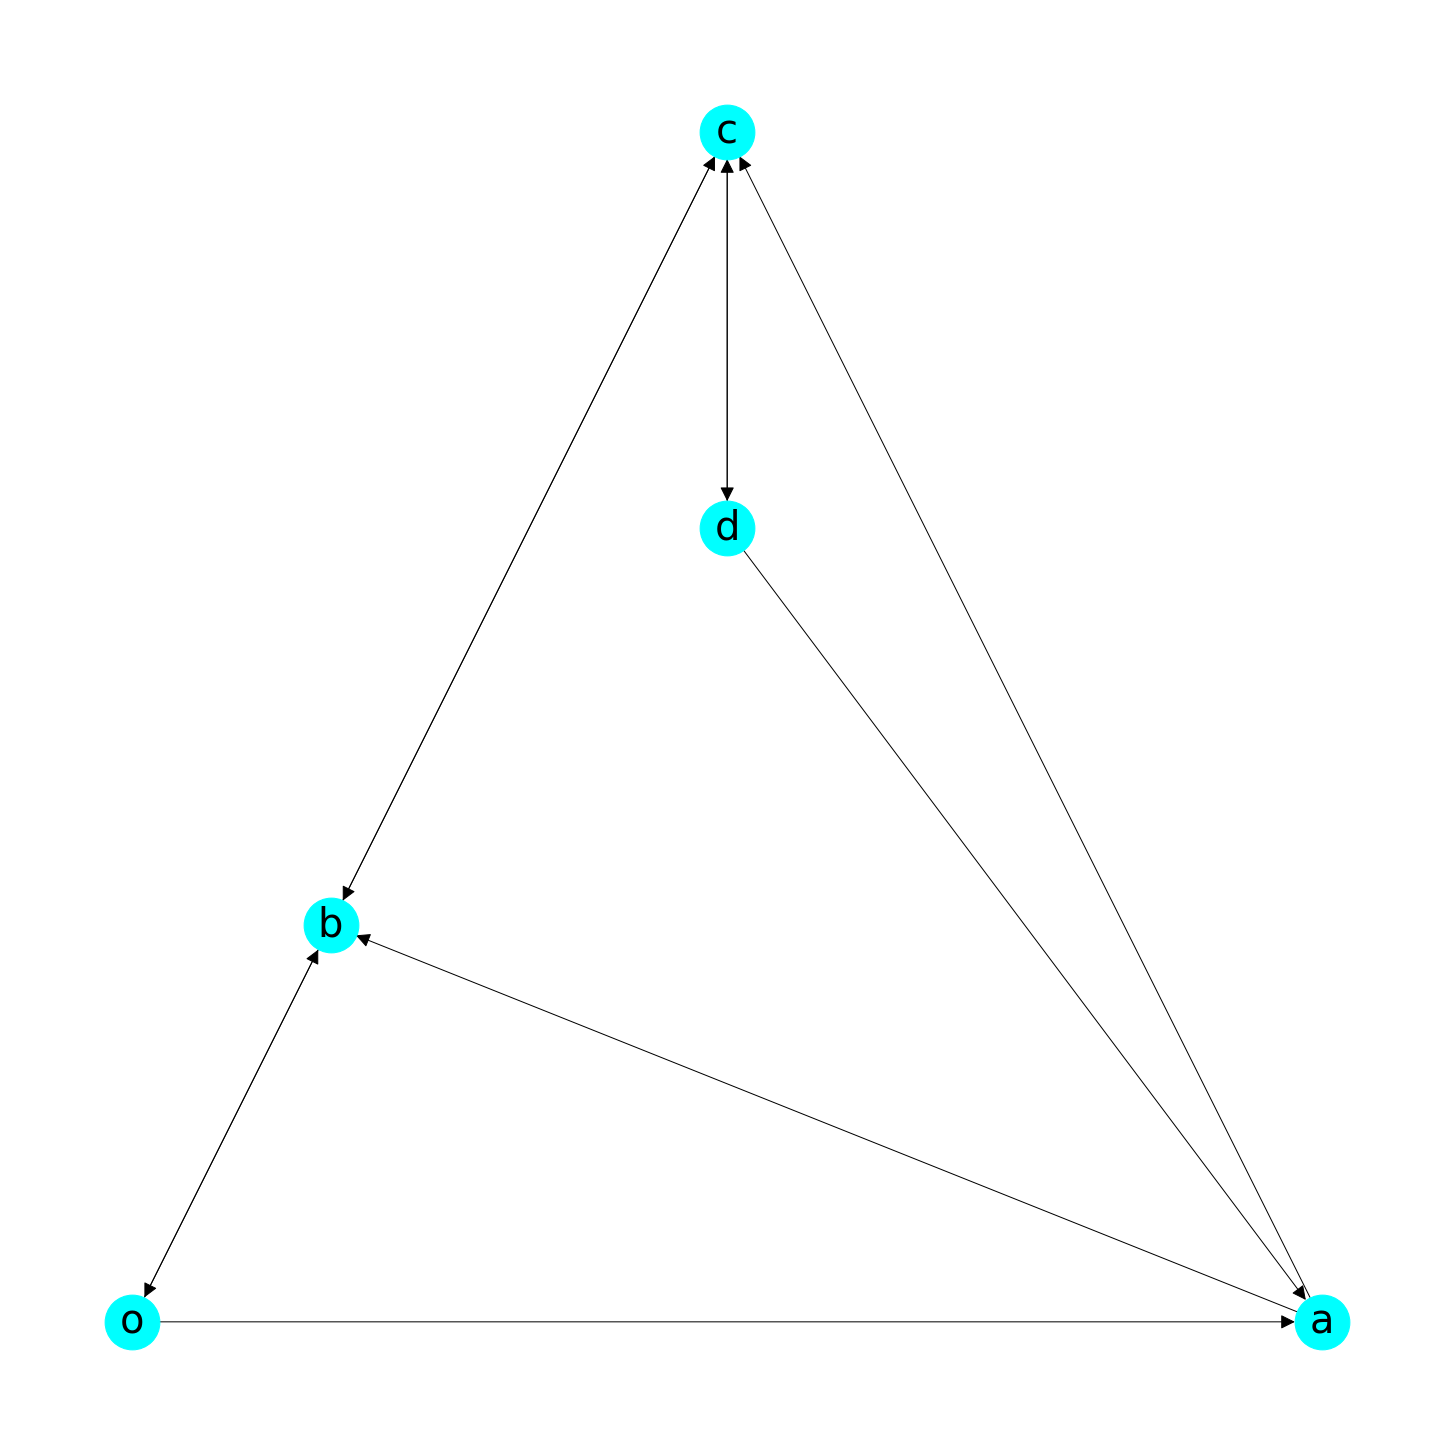

In [2]:
G = nx.DiGraph()
G.add_edges_from([('o','a'),('o','b'),('a','b'),('a','c'),('b','o'),('b','c'),('c','b'),('c','d'),('d','a'),('d','c')])

pos = nx.planar_layout(G)
plt.figure(figsize=(20, 20))
nx.draw(G, pos, node_color='#00ffff', arrowsize=30, node_size=3000, font_size=40, with_labels=True)

In [3]:
sorted_nodes = ['o', 'a', 'b', 'c', 'd']

# define a new graph with sorted nodes
H = nx.DiGraph()
H.add_nodes_from(sorted_nodes)
H.add_edges_from(G.edges(data=True))
print(list(H.nodes))

['o', 'a', 'b', 'c', 'd']


In [4]:
Lambda = [
[0, 2/5, 1/5, 0, 0],
[0, 0, 3/4, 1/4, 0],
[1/2, 0, 0, 1/2, 0],
[0, 0, 1/3, 0, 2/3],
[0, 1/3, 0, 1/3, 0]]

print("Lambda matrix: \n", np.array(Lambda))

Lambda matrix: 
 [[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.        ]]


In [5]:
w = np.sum(Lambda, axis=1)
w_star = np.max(w)

print("w vector: \n", w)
Q = Lambda/w_star # off-diagonal part of Q
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1)) # diagonal part of Q
print("Q matrix: \n", Q)

D = np.diag(w)
P = np.linalg.inv(D) @ Lambda
print("P matrix: \n", P)

w vector: 
 [0.6        1.         1.         1.         0.66666667]
Q matrix: 
 [[0.4        0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.33333333]]
P matrix: 
 [[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.5        0.         0.5        0.        ]]


In [6]:
# compute dominant eigenvector
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

nstates = len(pi_bar)

pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


In [7]:
# Simulates a random walk on a weighted graph, whose matrix T is the conditional probability matrix, starting from node 'start'.
# if end is not None the random walk stops the first time it reach node 'end'.
# Otherwise, it goes on for num_steps steps.
# If mode is 'global', global clock is used and the conditional probability matrix T must be the matrix Q (jump chain of the CTMC)
# If mode is 'local', local clock is used and the conditional probability matrix T must be the matrix P

# It returns a tuple(transition_times, pos, pos_names, t_next) such that:
# transition_times store the time instants at which transitions happen
# pos and pos_names keep trace of the visited states: pos refers to their position in 'nodes_list', pos_names to their name stored in elements of 'nodes_list'
# t_next stores the last waiting time, useful to compute: transition_times[-1] + t_next, end of the time horizon.
def RandomWalk_NotUniformTransitionProbability(T, mode, w, nodes_list, start, num_steps = 1000000, end = None):
    nstates = T.shape[0]
    # pos keep trace of the visited states
    pos = np.zeros(num_steps, dtype=int)
    size = num_steps
    pos[0] = nodes_list.index(start)
    
    # transition_times store the time instants at which transitions happen
    transition_times = np.zeros(num_steps)
    # random time to wait for the next transition
    if mode=='global':
        w_star = np.max(w)
        t_next = -np.log(np.random.rand())/w_star
    if mode=='local':
        t_next = -np.log(np.random.rand())/w[nodes_list.index(start)]

    # if the walk ends when 'end' is reached
    if end is not None:
        # no upper bound on the number of steps
        stop = False
        i = 1
        while not stop:
            if i==size:
                size = size*2
                pos.resize(size, refcheck=False)
                transition_times.resize(size, refcheck=False)
            # the next state to visit will be extracted according to the probabilities stored in the row of T corresponding to the current state.
            pos[i] = np.random.choice(nstates, p=T[pos[i-1],:])
            transition_times[i] = transition_times[i-1] + t_next
            if mode=='global': 
                t_next = -np.log(np.random.rand())/w_star # waiting time to the next transition
            if mode=='local':
                t_next = -np.log(np.random.rand())/w[pos[i]] # waiting time to the next transition
                
            # check if the walk has reached 'end' node
            # if so, end the walk
            if pos[i] == nodes_list.index(end):
                stop = True
                pos.resize(i+1, refcheck=False)
                transition_times.resize(i+1, refcheck=False)
            i+=1
    
    # if the walk ends after num_steps steps
    else:
        for i in range(1, num_steps):
            # the next state to visit will be extracted according to the probabilities stored in the row of T corresponding to the current state.
            pos[i] = np.random.choice(nstates, p=T[pos[i-1],:])
            transition_times[i] = transition_times[i-1] + t_next
            if mode=='global': 
                t_next = -np.log(np.random.rand())/w_star # waiting time to the next transition
            if mode=='local':
                t_next = -np.log(np.random.rand())/w[pos[i]]
    
    
    # map pos to node names
    pos_names = [nodes_list[i] for i in pos]
    
    return (transition_times, pos, pos_names, t_next)

In [8]:
# 1st approach: global clock with rate w_star and matrix Q

Time instants:
 [ 0.          0.15460358  1.17018897  1.35497245  2.04241829  2.42467328
  3.13895991  3.8960822   4.26527433  6.25083766  6.3646759   7.21316336
  8.62040375  9.22615131 10.62319115 10.89133964 10.97017856 12.3940691
 13.32198678 14.24911567 14.4754711  15.09232844 16.27905246 17.38230919
 17.53764877 18.8067048  20.70588985 21.32526329 21.74642389 21.9287509
 23.55041955 24.68723911 25.28285657 25.92911172 26.38767312 26.88651149
 27.57528814 27.95279921 28.90200441 28.91911546 29.16875252 29.24859617
 29.84598592 30.31468138 31.73534637 32.05827421 32.08147943 32.10007058
 33.01983461 33.66030247 36.0719611  36.17183363 36.78941335 37.83711375
 38.10628805 39.15661322 39.65855926 40.35462731 40.99262115 41.61797651
 42.01979101 44.0685768  44.55979939 45.54215522 48.1648092  49.17388286
 50.1531744  50.45307334 52.2664196  53.66258239 53.71216356 55.97810985
 56.57974508 57.93983296 58.14583166 58.7785276  59.61291693 60.08931693
 60.21782745 61.15704419 63.65583416 

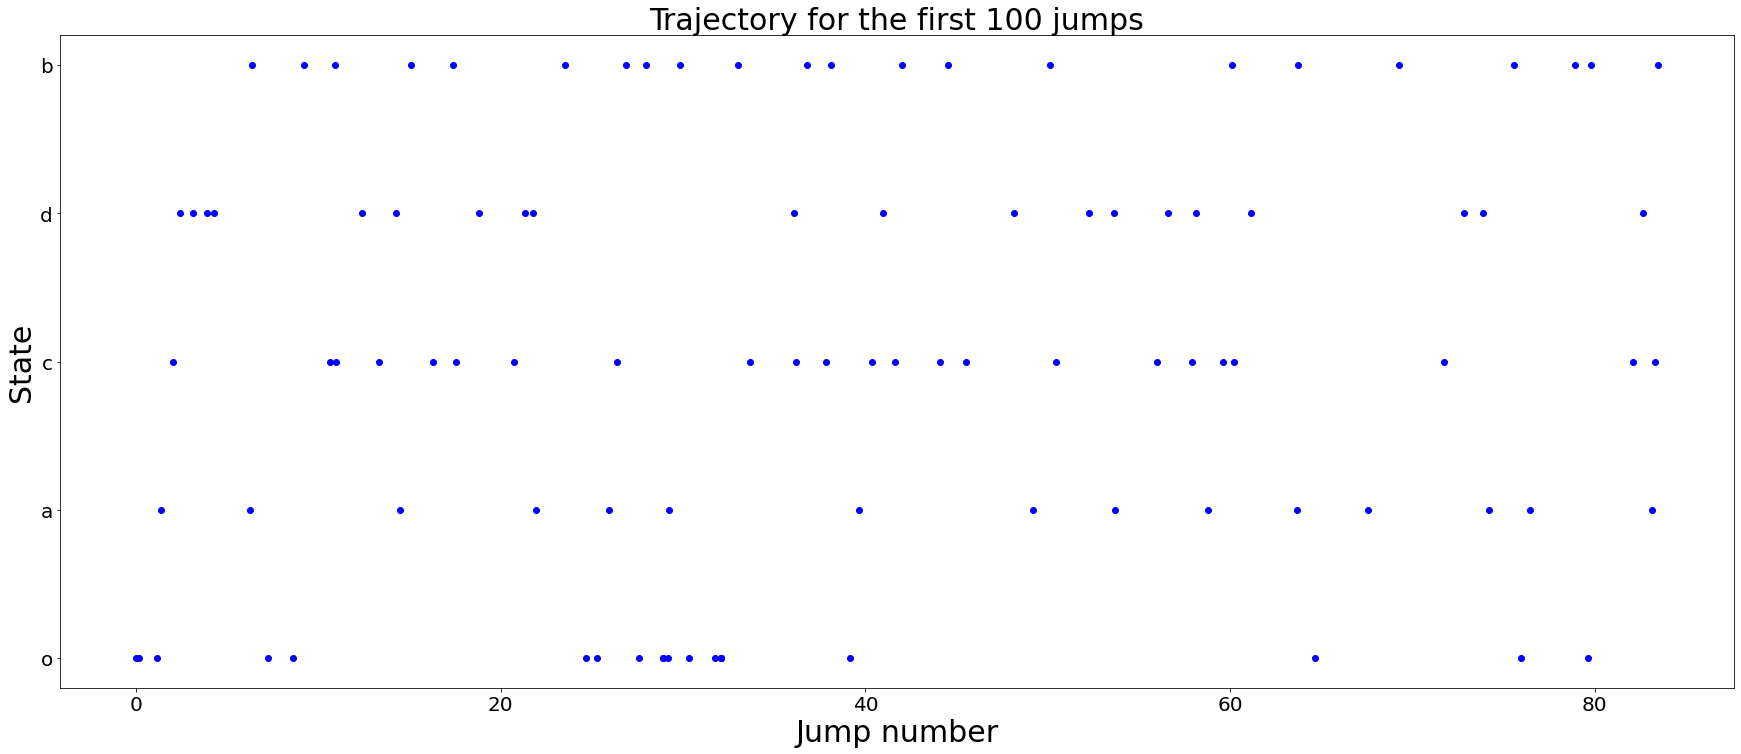

In [13]:
transition_times, pos, pos_names, t_next = RandomWalk_NotUniformTransitionProbability(Q, 'global', w, sorted_nodes, 'o')
# plot the trajectory for the first 100 jumps
plt.figure(figsize=(30, 12))
plt.plot(transition_times[0:100], pos_names[0:100], 'bo')
plt.title('Trajectory for the first 100 jumps', fontsize = 30)
plt.xlabel('Jump number', fontsize = 30)
plt.ylabel('State', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# print states for the first 100 time instants
print("Time instants:\n", transition_times[0:100])
print("States:\n", pos_names[0:100])

In [10]:
# Estimate pi
pi_estimate = np.zeros(nstates)

intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)
# for each state in the state space
for state in range(nstates):
    # identify the steps when we visited that state during the process
    visits = np.argwhere(pos == state)
    # the estimate of the invariant measure for that state is equal to the time spent on the state divided the total time of the process
    pi_estimate[state] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
    
print("Estimate of pi_bar:", pi_estimate)

Estimate of pi_bar: [0.18495043 0.14800061 0.22185238 0.2227342  0.22246238]


In [14]:
# 2nd approach: local clocks with rates w_i and matrix P

Time instants:
 [  0.           3.1636635    4.37424704   4.41870679   7.59610241
   7.73818854   8.70343205  10.04544486  13.46248743  14.33542367
  16.06569419  16.44112064  16.44696261  17.80873929  19.4228384
  20.21972117  20.79168267  22.433904    22.85786007  23.35634984
  23.85020495  23.86402658  23.98240668  24.18744931  25.55212687
  25.97553895  27.49712672  29.62889299  32.50576977  34.26334955
  34.67832101  36.2664679   36.37364018  39.27381287  40.66720417
  42.38279933  42.73562675  43.78844074  44.2208267   45.65249166
  48.09532142  51.67683744  52.52312074  53.09180148  54.40621955
  56.37475003  57.17899307  58.44301441  58.97227455  59.51283347
  62.23678429  64.9856436   65.4036888   65.99001963  66.74111091
  66.85316149  67.30506005  67.8956929   69.0886547   69.5384268
  70.57695343  71.33129739  71.69980653  77.49218725  77.53719374
  79.21823372  79.28612446  79.62348544  81.32913738  82.61907233
  83.7613186   84.80493816  88.01094723  88.0951148   89.26696

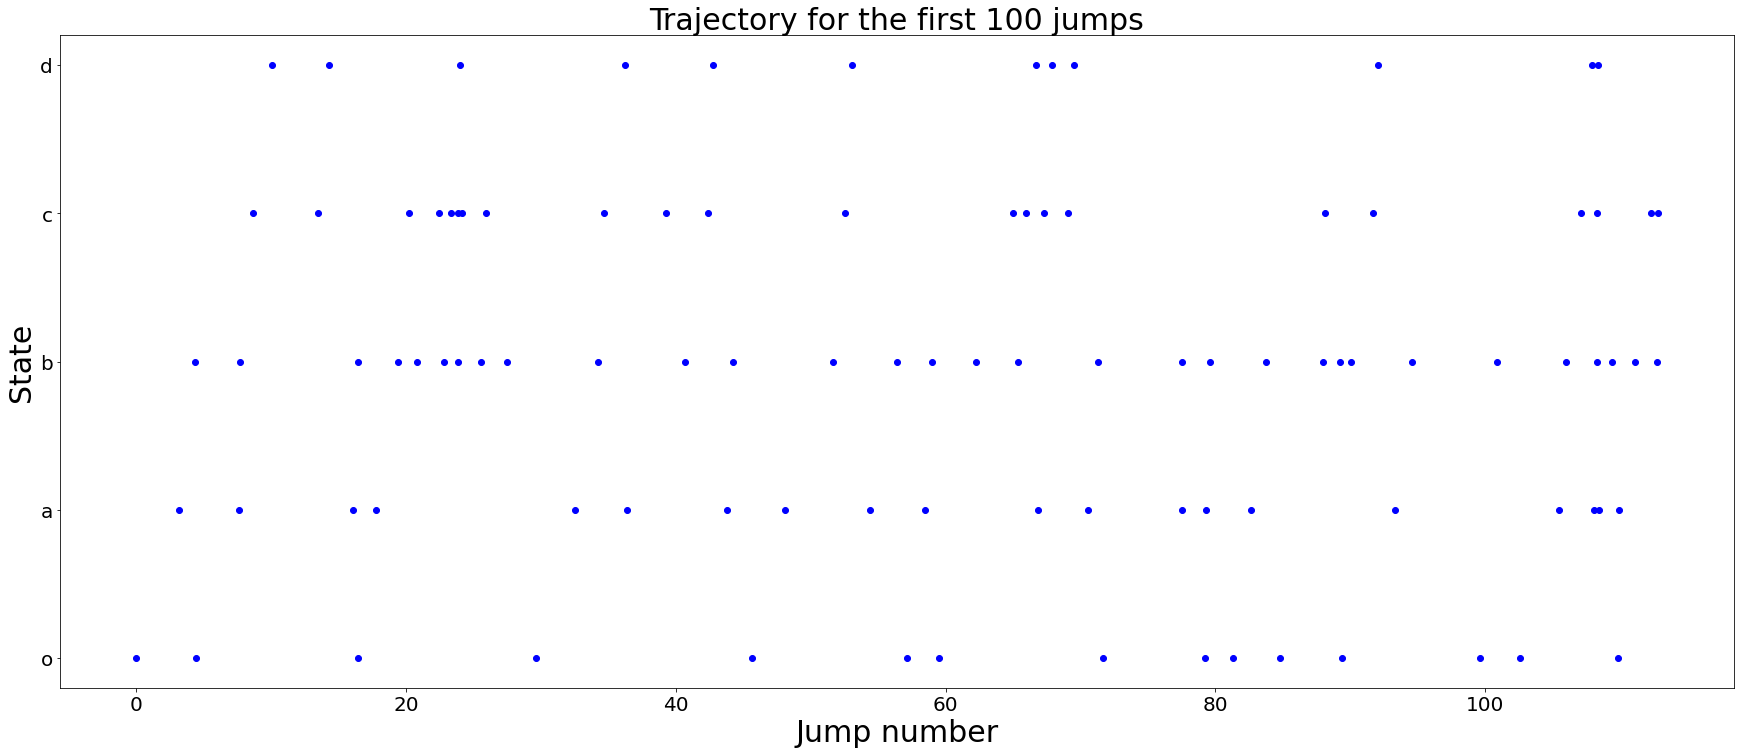

In [16]:
transition_times, pos, pos_names, t_next = RandomWalk_NotUniformTransitionProbability(P, 'local', w, sorted_nodes, 'o')
# plot the trajectory for the first 100 jumps
plt.figure(figsize=(30, 12))
plt.plot(transition_times[0:100], pos_names[0:100], 'bo')
plt.title('Trajectory for the first 100 jumps', fontsize = 30)
plt.xlabel('Jump number', fontsize = 30)
plt.ylabel('State', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# print states for the first 100 time instants
print("Time instants:\n", transition_times[0:100])
print("States:\n", pos_names[0:100])

In [13]:
# Estimate pi
pi_estimate = np.zeros(nstates)

intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)
# for each state in the state space
for state in range(nstates):
    # identify the steps when we visited that state during the process
    visits = np.argwhere(pos == state)
    # the estimate of the invariant measure for that state is equal to the time spent on the state divided the total time of the process
    pi_estimate[state] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
    
print("Estimate of pi_bar:", pi_estimate)

Estimate of pi_bar: [0.18427333 0.14841363 0.22174797 0.22268592 0.22287916]


The expected hitting time  $\hat{x}= (\mathbb{E}_i[T_S])_{i \in R}$ for the set $S$ and for all nodes $i \in R = \mathcal V \setminus S$ is the expected value of $T_s$ for the random walk $X(t)$, assuming that the random walk starts in $i$, with hitting time:

$$
T_s = \min\{t \ge 0 \mid X(t) \in S\}
$$

It can be computed by solving the system of equations

$$
\hat{x} = \hat{w_{inv}} + \hat{P}\hat{x},
$$ 

where $\hat{P}$ is obtained from $P$ (the normalized weight matrix of the graph) by removing the rows and columns corresponding to the nodes in the set $S$ and $w_{inv}$ such that $w_{{inv}_i} = 1/w_i$ ($w = \Lambda\mathbf{1}$) 

More explicitly, the expected hitting times can be expressed as

$$
\hat{x} = (I - \hat{P})^{-1} \hat{w_{inv}}
$$

$(I - \hat{P})$ is invertible only if $V \setminus S$ has at least a link pointing to $S$. Indeed, if $(I - \hat{P})$ is not invertible, the random walk starting from nodes in $V \setminus S$ cannot hit nodes in $S$, and the hitting times diverge.

In [21]:
def hitting_time(G, S, P):
    n_nodes = G.number_of_nodes()
    R = [node for node in range(n_nodes) if node not in S]


    hatP = P[np.ix_(R, R)]

    winv = 1/w
    winvhat = winv[np.ix_(R)]

    hatx = np.linalg.solve((np.identity(n_nodes-len(S))-hatP),winvhat)
    # map node to position of node in hatx
    map = {}
    for i in range(n_nodes-len(S)):
        map[R[i]] = i


    hitting_s = np.zeros(n_nodes)

    for r in R:
        hitting_s[r] = hatx[map[r]]

    return hitting_s

In [15]:
np.set_printoptions(formatter={'float': '{: 0.7f}'.format})
print("Nodes in vectors:")
print("  ", end='')
for n in (sorted_nodes):
    print(n + "           ", end='')
print()
for node in range(len(sorted_nodes)):
    h_times = hitting_time(G,[node], P)
    print(h_times, "\tExpected hitting time with S={" + sorted_nodes[node] + "}")

Nodes in vectors:
  o           a           b           c           d           
[ 0.0000000  8.0000000  6.0000000  10.0000000  10.5000000] 	Expected hitting time with S={o}
[ 3.5714286  0.0000000  5.7142857  5.8571429  4.4285714] 	Expected hitting time with S={a}
[ 3.0000000  2.0000000  0.0000000  4.0000000  4.5000000] 	Expected hitting time with S={b}
[ 5.4285714  3.7857143  3.7142857  0.0000000  3.3928571] 	Expected hitting time with S={c}
[ 8.7857143  7.1428571  7.0714286  3.3571429  0.0000000] 	Expected hitting time with S={d}


The expected hitting-time $\mathbb{E}_o[T_d]$ is the expected value of $T_d$ for the random walk $X(t)$, assuming that the random walk starts in $o$ and ends in $d$, with hitting time:

$$
T_d = \min\{t \ge 0 \mid X(t) = d\}
$$

It can be computed by solving the system of equations

$$
\hat{x} = \hat{w_{inv}} + \hat{P}\hat{x},
$$ 

where $\hat{P}$ is obtained from $P$ (the normalized weight matrix of the graph) by removing the row and the column corresponding to the node $d$ and $w_{inv}$ such that $w_{{inv}_i} = 1/w_i$ ($w = \Lambda\mathbf{1}$).       
${\hat{x}}_{i}$ refers to the $i^{th}$ node (node $o$ in position $i=0$)

More explicitly, the expected hitting times can be expressed as

$$
\hat{x} = (I - \hat{P})^{-1} \hat{w_{inv}}
$$

$(I - \hat{P})$ is invertible since $V \setminus \{d\}$ has at least a link pointing to $\{d\}$.

In [22]:
ind = sorted_nodes.index('d')
h_time = hitting_time(G,[ind], P)[sorted_nodes.index('o')]
print("Expected hitting time with S={" + sorted_nodes[ind] + "} and i=o:", h_time)

Expected hitting time with S={d} and i=o: 8.785714285714285


In [71]:
avg_t_approaches = np.zeros(2)

# 1st approach: global clock with rate w_star and matrix Q

n_simul = 1000000

coll_t = np.zeros(n_simul)
for j in range(0, n_simul):
    transition_times, pos, pos_names, t_next = RandomWalk_NotUniformTransitionProbability(Q, 'global', w, sorted_nodes, 'o', end='d')
    t = transition_times[-1]
    coll_t[j] = t
avg_t = coll_t.mean()

print("Average time to move from node o to node d:", avg_t)

avg_t_approaches[0] = avg_t

Average time to move from node o to node d: 8.783223479635163


In [72]:
# 2nd approach: local clocks with rates w_i and matrix P

n_simul = 1000000

coll_t = np.zeros(n_simul)
for j in range(0, n_simul):
    transition_times, pos, pos_names, t_next = RandomWalk_NotUniformTransitionProbability(P, 'local', w, sorted_nodes, 'o', end='d')
    t = transition_times[-1]
    coll_t[j] = t
avg_t = coll_t.mean()

print("Average time to move from node o to node d:", avg_t)

avg_t_approaches[1] = avg_t

Average time to move from node o to node d: 8.781031115413898


In [73]:
print("1st approach.")
print("expected hitting time computed analytically =", h_time, "\n")

print("expected hitting time estimated =", avg_t_approaches[0], "\n")

error = abs(h_time-avg_t_approaches[0])
print("Comparison: ", error)

print("\n")
print("2nd approach.")
print("expected hitting time computed analytically =", h_time, "\n")

print("expected hitting time estimated =", avg_t_approaches[1], "\n")

error = abs(h_time-avg_t_approaches[1])
print("Comparison: ", error)

1st approach.
expected hitting time computed analytically = 8.785714285714285 

expected hitting time estimated = 8.783223479635163 

Comparison:  0.0024908060791215547


2nd approach.
expected hitting time computed analytically = 8.785714285714285 

expected hitting time estimated = 8.781031115413898 

Comparison:  0.004683170300387118


The expected return time $\mathbb{E}_i[T_i^+]$ is the expected value of $T_i^+$ for the random walk $X(t)$, assuming that the random walk starts in $i$, with return time:

$$
T_i^+ = \inf\{t \ge 0 \mid X(t) = i\ \land X(s) \neq i\ s \in (0,t)\}
$$

It can be computed thanks to the following relations:

$$
\mathbb{E}_i[T_i^+] = \frac{1}{w_i} + \sum_{j} P_{ij} \mathbb{E}_j[T_i]
$$

where $\mathbb{E}_j[T_i]$ is the expected hitting time to the set $S=\{i\}$ starting from $j$.

In [33]:
ht = np.column_stack(tuple(hitting_time(G,[i], P) for i in range(len(G))))
return_i = np.diag(P@ht)+1/w

print("Nodes in vectors:")
print("  ", end='')
for n in (sorted_nodes):
    print(n + "           ", end='')
print()
print(return_i, "return times")

r_time = return_i[1]

Nodes in vectors:
  o           a           b           c           d           
[ 9.0000000  6.7500000  4.5000000  4.5000000  6.7500000] return times


The expected return time $\mathbb{E}_i[T_i^+]$ can also be computed thanks to the following formula:

$$
\mathbb{E}_i[T_i^+] = \frac{1}{w_i \bar{\pi}_i}
$$

In [47]:
return_i_first = 1/(w*pi_bar)
print("Nodes in vectors:")
print("  ", end='')
for n in (sorted_nodes):
    print(n + "           ", end='')
print()
print(return_i_first, "return times")

Nodes in vectors:
  o           a           b           c           d           
[ 9.0000000  6.7500000  4.5000000  4.5000000  6.7500000] return times


In [52]:
print("Does the two vectors have the same elements?", sum(np.isclose(return_i, return_i_first))==len(return_i))

Does the two vectors have the same elements? True


The 2 ways lead to the same result.

In [36]:
avg_t_approaches = np.zeros(2)

# 1st approach: global clock with rate w_star and matrix Q

n_simul = 1000000

coll_t = np.zeros(n_simul)
for j in range(0, n_simul):
    transition_times, pos, pos_names, t_next = RandomWalk_NotUniformTransitionProbability(Q, 'global', w, sorted_nodes, 'a', end='a')
    t = transition_times[-1]
    coll_t[j] = t
avg_t = coll_t.mean()

print("Average time to leave a and then return to a:", avg_t)

avg_t_approaches[0] = avg_t

Average time to leave a and then return to a: 6.754683772330571


In [64]:
# 2nd approach: local clocks with rates w_i and matrix P

n_simul = 1000000

coll_t = np.zeros(n_simul)
for j in range(0, n_simul):
    transition_times, pos, pos_names, t_next = RandomWalk_NotUniformTransitionProbability(P, 'local', w, sorted_nodes, 'a', end='a')
    t = transition_times[-1]
    coll_t[j] = t
avg_t = coll_t.mean()

print("Average time to leave a and then return to a:", avg_t)

avg_t_approaches[1] = avg_t

Average time to leave a and then return to a: 6.748101917183023


In [65]:
print("1st approach.")
print("expected hitting time computed analytically =", r_time, "\n")

print("expected hitting time estimated =", avg_t_approaches[0], "\n")

error = abs(r_time-avg_t_approaches[0])
print("Comparison: ", error)

print("\n")
print("2nd approach.")
print("expected hitting time computed analytically =", r_time, "\n")

print("expected hitting time estimated =", avg_t_approaches[1], "\n")

error = abs(r_time-avg_t_approaches[1])
print("Comparison: ", error)

1st approach.
expected hitting time computed analytically = 6.749999999999998 

expected hitting time estimated = 6.754683772330571 

Comparison:  0.004683772330572822


2nd approach.
expected hitting time computed analytically = 6.749999999999998 

expected hitting time estimated = 6.748101917183023 

Comparison:  0.0018980828169752328


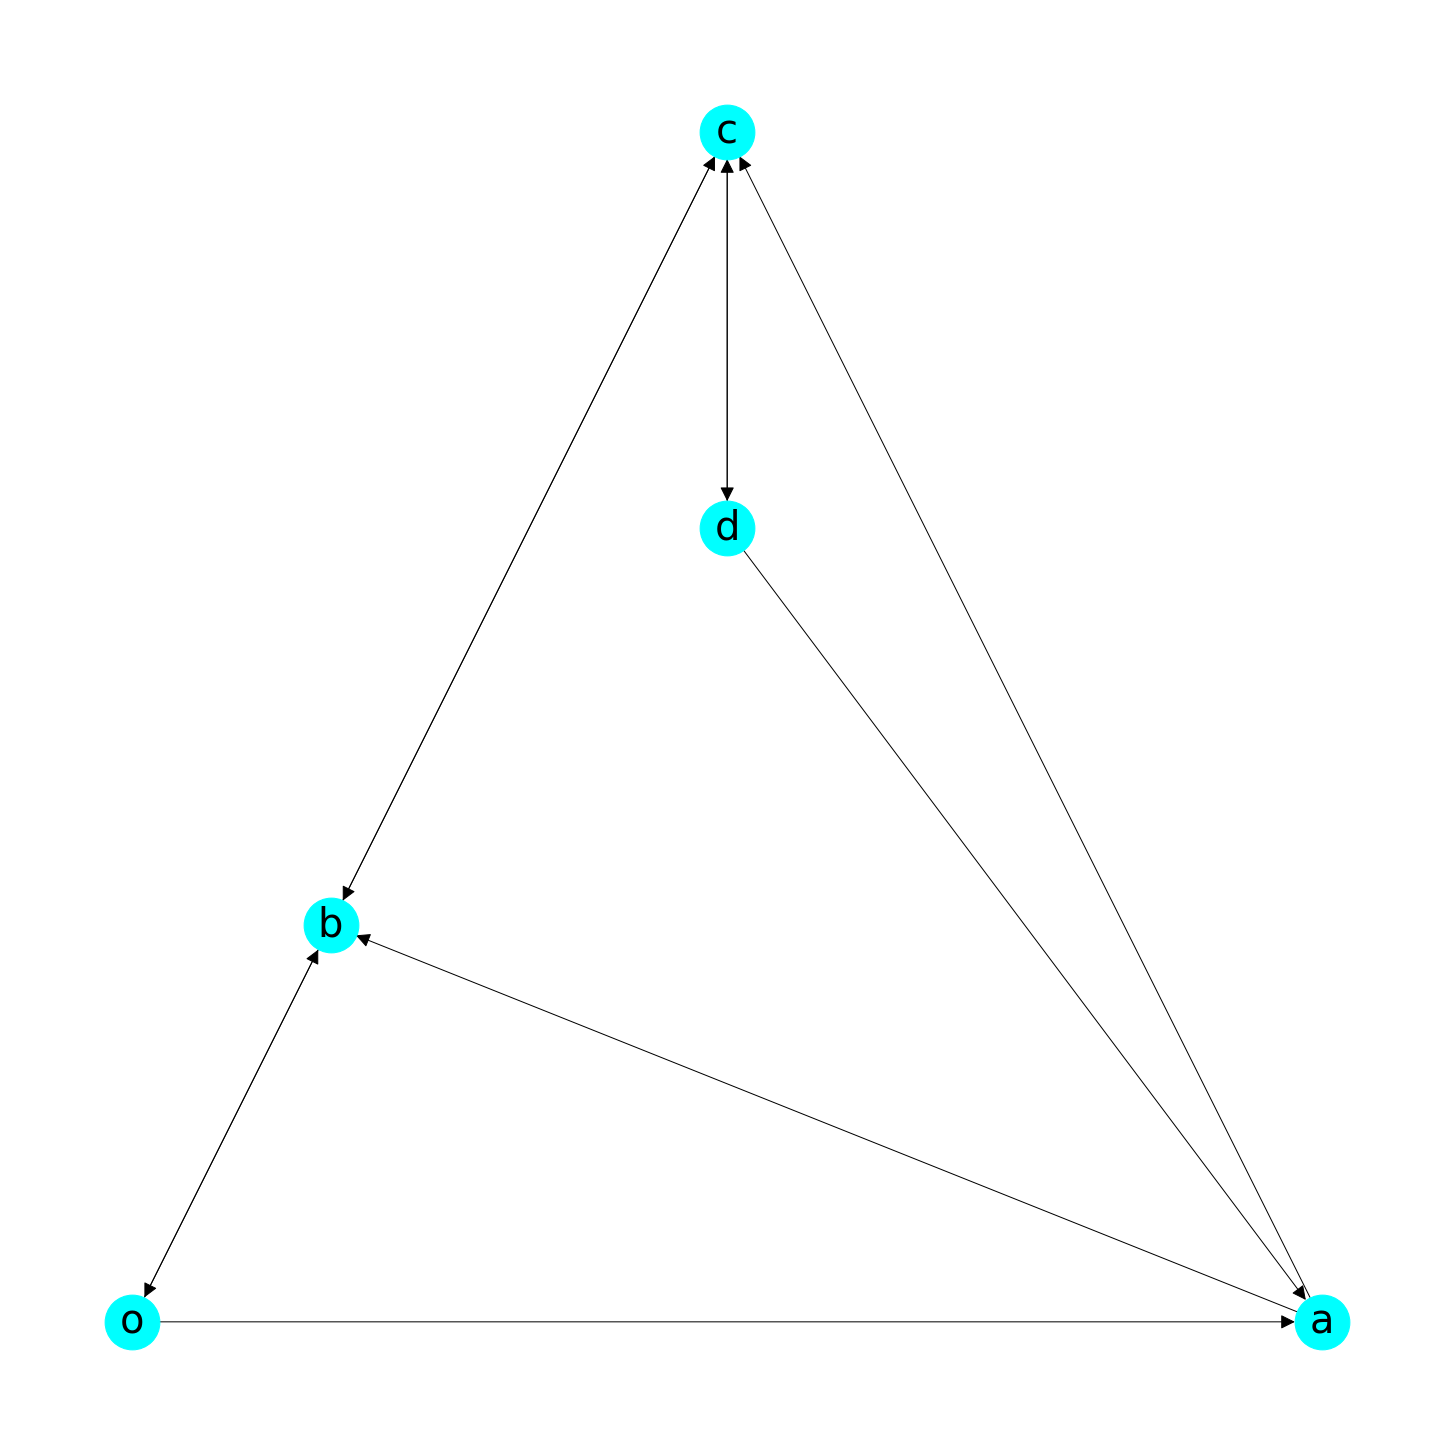

In [17]:
G = nx.DiGraph()
G.add_weighted_edges_from([('o','a',2/5),('o','b',1/5),('a','b',3/4),('a','c',1/4),('b','o',1/2),('b','c',1/2),('c','b',1/3),('c','d',2/3),('d','a',1/3),('d','c',1/3)])

pos = nx.planar_layout(G)
plt.figure(figsize=(20, 20))
nx.draw(G, pos, node_color='#00ffff', arrowsize=30, node_size=3000, font_size=40, with_labels=True)

In [18]:
sorted_nodes = ['o', 'a', 'b', 'c', 'd']

# define a new graph with sorted nodes
H = nx.DiGraph()
H.add_nodes_from(sorted_nodes)
H.add_edges_from(G.edges(data=True))
print(list(H.nodes))

['o', 'a', 'b', 'c', 'd']


In [19]:
# Compute P matrix
A = nx.adjacency_matrix(H) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A

n_nodes = H.number_of_nodes()

print("Weight matrix (Lambda):\n", A)
print("P matrix:\n", P)

Weight matrix (Lambda):
 [[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.        ]]
P matrix:
 [[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.5        0.         0.5        0.        ]]


In [20]:
n_simulation = 5
for i in range(n_simulation):
    x0 = np.random.rand(n_nodes)*3 # arbitrary initial condition
    print("x(0):", x0)
    x = x0
    t_final = 100

    for n in range(t_final):
        x = P @ x
    print("x(" + str(t_final) + "):", x)
    print("\n")

x(0): [2.60472579 0.35998263 2.47613314 1.41600574 2.35030583]
x(100): [1.82644193 1.82644193 1.82644193 1.82644193 1.82644193]


x(0): [0.9509636  1.14013392 1.87075562 1.57074194 1.10692313]
x(100): [1.41261323 1.41261323 1.41261323 1.41261323 1.41261323]


x(0): [2.38933465 0.97058101 1.14631436 2.553456   2.3505635 ]
x(100): [1.85440018 1.85440018 1.85440018 1.85440018 1.85440018]


x(0): [2.29818439 2.09361094 0.22872634 1.82625269 0.60377282]
x(100): [1.30495489 1.30495489 1.30495489 1.30495489 1.30495489]


x(0): [0.48752805 2.79664642 2.46249923 0.16659191 0.40426432]
x(100): [1.30612061 1.30612061 1.30612061 1.30612061 1.30612061]




Condensation graph:
{0: {'members': {'a', 'b', 'd', 'o', 'c'}}}

0 is a sink component

1 sink component in G.


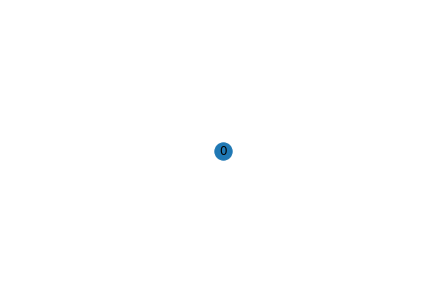

In [6]:
CG = nx.algorithms.components.condensation(H)
nx.draw(CG, with_labels=True)

print("Condensation graph:")
print(dict(CG.nodes))
print()

w = np.sum(nx.adjacency_matrix(CG).toarray(), axis=1)
sink_n = 0
for node in dict(CG.nodes):
    if w[node] == 0:
        print(node, "is a sink component")
        sink_n += 1
print()
print(sink_n, "sink component in G.")

1 sink in the condensation graph: $0$ (with nodes b, d, o, a, c)       
$\mathcal{W}_0 = \{b, d, o, a, c\}$.       
Strongly connected graph

In [7]:
w,v = np.linalg.eig(P.T)

for i in range(len(G)):
    print(i+1)
    print("eigenvalue: ", w[i])
    print("eigenvector: ", v[i])
    print()
    
print("\nInvariant distributions pi:")
for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi/np.sum(pi) # normalization
    print("pi"+str(index+1), "=", pi)
inv_dist = pi

1
eigenvalue:  (1.0000000000000009+0j)
eigenvector:  [ 0.28221626+0.j          0.54177301+0.j         -0.30708221+0.29373491j
 -0.30708221-0.29373491j -0.30594628+0.j        ]

2
eigenvalue:  (0.348057396412199+0j)
eigenvector:  [ 0.37628835+0.j  0.08768483+0.j  0.64093062+0.j  0.64093062-0.j
 -0.08094676+0.j]

3
eigenvalue:  (-0.28502603801202403+0.527059095882918j)
eigenvector:  [ 0.56443252+0.j          0.37713621+0.j         -0.13457846-0.49114513j
 -0.13457846+0.49114513j  0.47605566+0.j        ]

4
eigenvalue:  (-0.28502603801202403-0.527059095882918j)
eigenvector:  [ 0.56443252+0.j         -0.34526874+0.j         -0.24334907-0.08655986j
 -0.24334907+0.08655986j -0.62304502+0.j        ]

5
eigenvalue:  (-0.778005320388151+0j)
eigenvector:  [ 0.37628835+0.j         -0.6613253 +0.j          0.04407911+0.28397008j
  0.04407911-0.28397008j  0.5338824 +0.j        ]


Invariant distributions pi:
pi1 = [0.13043478 0.17391304 0.26086957 0.26086957 0.17391304]


$\pi_1$ is such that ${\pi_1}_i>0$ if and ony if $i \in \mathcal{W}_0$.     
(${\pi_1}_i>0, \forall i$ since $\mathcal{G}$ is strongly connected).

In [8]:
sink_component = list(G.subgraph(c).copy() for c in nx.algorithms.components.attracting_components(G))[0]
print("Is the sink component aperiodic?:",nx.is_aperiodic(sink_component))

Is the sink component aperiodic?: True


The sink component of the condensation graph: $0$ is aperiodic

Since:
- the condensation graph of $\mathcal{G}$ has 1 sink
- the sink component of the graph is aperiodic,

$$
\lim_{t \to +\infty} x(t) = \alpha \mathbf{1},
$$

i.e., the dynamics converges to a consensous state for every initial condition $x(0)$

$x_i(0) = \xi_i$ with $i \in \mathcal{V}$ and $\xi_i$ i.i.d. random variable with variance $\sigma^2$     

Consensous value $\alpha = \pi' x(0)$:      
$$
\quad \sigma_{\alpha}^2 = \sigma^2 \sum_{i} \pi_i^2 
$$
since $\xi_i$ indipendent random variables.

Since $\mathcal{G}$ is strongly connected, $\sum_{i} \pi_i^2 < \sum_{i} \pi_i = 1$ and $\quad \sigma_{\alpha}^2 < \sigma^2$

In [9]:
# xi_i indipendent random variables uniformly distributed in U(up,low)
up = 1
low = 0
sigma = ((up-low)*(up-low))/12
mu = (up-low)/2
sigma_alpha = sigma*sum(np.power(inv_dist,2))
print("sigma:", sigma, "- sigma_alpha:", sigma_alpha)
print("Is sigma greater than sigma_alpha?", sigma>sigma_alpha)
sigma_alpha__teor = sigma_alpha

sigma: 0.08333333333333333 - sigma_alpha: 0.01780088216761184
Is sigma greater than sigma_alpha? True


In [10]:
# numerical simulation

In [11]:
n_simulation = 1000000
alfa_err = np.zeros(n_simulation)

for i in range(n_simulation):
    x = np.random.rand(n_nodes)
    t_final = 100
    for n in range(t_final):
        x = P @ x
    alfa_err[i] = (mu - np.mean(x))*(mu - np.mean(x))

print("Variance of the node states:", sigma)
print("Variance of the consensus state:", np.mean(alfa_err), "\n")
sigma_alpha__simul = np.mean(alfa_err)

Variance of the node states: 0.08333333333333333
Variance of the consensus state: 0.01781571052710574 



In [12]:
print("Theorical sigma_alpha =", sigma_alpha__teor)
print("Computed sigma_alpha in simulation =", sigma_alpha__simul)
error = abs(sigma_alpha__teor-sigma_alpha__simul)
print("Difference: ", error)

Theorical sigma_alpha = 0.01780088216761184
Computed sigma_alpha in simulation = 0.01781571052710574
Difference:  1.4828359493897908e-05


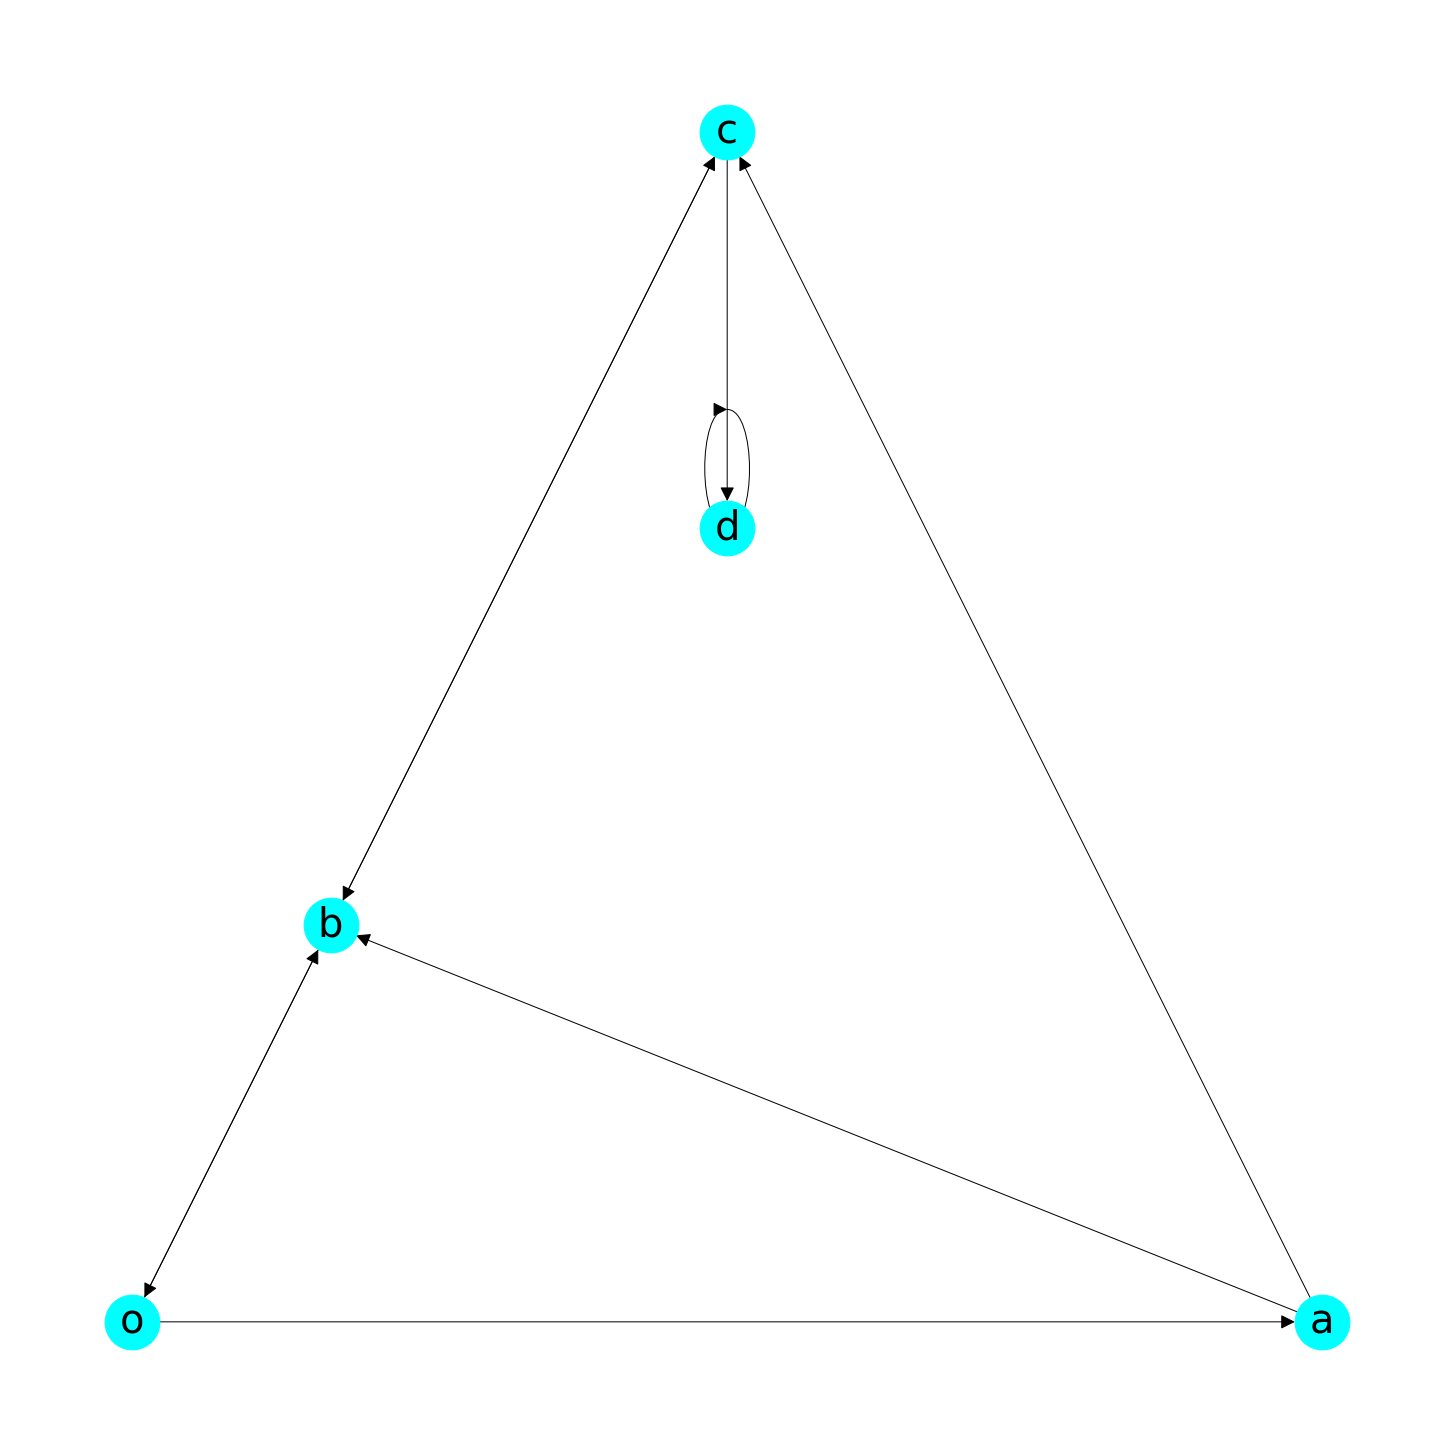

In [25]:
G.remove_edge('d', 'a')
G.remove_edge('d', 'c')
G.add_weighted_edges_from([('d', 'd', 1)]) # Since 'd' has not outgoing links, add a self-loop so that D is not a singular matrix
pos = nx.planar_layout(G)
plt.figure(figsize=(20, 20))
nx.draw(G, pos, node_color='#00ffff', arrowsize=30, node_size=3000, font_size=40, with_labels=True)

In [26]:
sorted_nodes = ['o', 'a', 'b', 'c', 'd']

# define a new graph with sorted nodes
H = nx.DiGraph()
H.add_nodes_from(sorted_nodes)
H.add_edges_from(G.edges(data=True))
print(list(H.nodes))

['o', 'a', 'b', 'c', 'd']


In [28]:
# Compute P matrix
A = nx.adjacency_matrix(H) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A

n_nodes = H.number_of_nodes()

print("Weight matrix (Lambda):\n", A)
print("P matrix:\n", P)

Weight matrix (Lambda):
 [[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.         0.         0.         1.        ]]
P matrix:
 [[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.         0.         0.         1.        ]]


In [29]:
n_simulation = 5
for i in range(n_simulation):
    x0 = np.random.rand(n_nodes)*3 # arbitrary initial condition
    print("x(0):", x0)
    x = x0
    t_final = 100

    for n in range(t_final):
        x = P @ x
    print("x(" + str(t_final) + "):", x)
    print("\n")

x(0): [1.66699417 1.55889395 1.13164778 2.16694378 0.90850786]
x(100): [0.90850787 0.90850787 0.90850786 0.90850786 0.90850786]


x(0): [2.00610653 1.62664346 0.61306634 0.06366457 1.85470007]
x(100): [1.85470006 1.85470006 1.85470006 1.85470007 1.85470007]


x(0): [0.35605647 1.90722388 0.00654206 2.86824081 0.26521573]
x(100): [0.26521574 0.26521573 0.26521573 0.26521573 0.26521573]


x(0): [0.6618103  1.1301443  0.22294462 2.66193632 1.26645717]
x(100): [1.26645717 1.26645717 1.26645717 1.26645717 1.26645717]


x(0): [0.10120323 1.20414951 0.96172749 1.72894778 0.84052098]
x(100): [0.84052098 0.84052098 0.84052098 0.84052098 0.84052098]




Condensation graph:
{0: {'members': {'d'}}, 1: {'members': {'b', 'o', 'c', 'a'}}}

0 is a sink component

1 sink component in G.


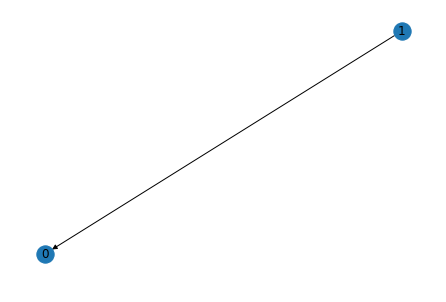

In [30]:
CG = nx.algorithms.components.condensation(H)
nx.draw(CG, with_labels=True)

print("Condensation graph:")
print(dict(CG.nodes))
print()

w = np.sum(nx.adjacency_matrix(CG).toarray(), axis=1)
sink_n = 0
for node in dict(CG.nodes):
    if w[node] == 0:
        print(node, "is a sink component")
        sink_n += 1
print()
print(sink_n, "sink component in G.")

1 sink in the condensation graph: $0$ (with nodes d)       
$\mathcal{W}_0 = \{d\}$.       

In [31]:
w,v = np.linalg.eig(P.T)

for i in range(len(G)):
    print(i+1)
    print("eigenvalue: ", w[i])
    print("eigenvector: ", v[i])
    print()
    
print("\nInvariant distributions pi:")
for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi/np.sum(pi) # normalization
    print("pi"+str(index+1), "=", pi)
inv_dist = pi

1
eigenvalue:  (1+0j)
eigenvector:  [ 0.        +0.j         -0.18887857+0.j          0.29425598-0.31175658j
  0.29425598+0.31175658j -0.07679274+0.j        ]

2
eigenvalue:  (0.8233696644236804+0j)
eigenvector:  [ 0.        +0.j -0.15293136+0.j -0.56884327+0.j -0.56884327-0.j
  0.38304854+0.j]

3
eigenvalue:  (-0.3448588855558884+0.3653690381696633j)
eigenvector:  [ 0.        +0.j        -0.31103376+0.j         0.02485882+0.4300481j
  0.02485882-0.4300481j  0.02052699+0.j       ]

4
eigenvalue:  (-0.3448588855558884-0.3653690381696633j)
eigenvector:  [ 0.        +0.j         -0.23531316+0.j          0.48854423-0.10591322j
  0.48854423+0.10591322j -0.79329688+0.j        ]

5
eigenvalue:  (-0.1336518933119017+0j)
eigenvector:  [ 1.        +0.j         0.88815685+0.j        -0.23881576-0.0123783j
 -0.23881576+0.0123783j  0.46651409+0.j       ]


Invariant distributions pi:
pi1 = [0. 0. 0. 0. 1.]


$\pi_1$ is such that ${\pi_1}_i>0$ if and ony if $i \in \mathcal{W}_0$.

In [32]:
sink_component = list(G.subgraph(c).copy() for c in nx.algorithms.components.attracting_components(G))[0]
print("Is the sink component aperiodic?:",nx.is_aperiodic(sink_component))

Is the sink component aperiodic?: True


The sink component of the condensation graph: $0$ is aperiodic

Since:
- the condensation graph of $\mathcal{G}$ has 1 sink
- the sink component of the graph is aperiodic,

$$
\lim_{t \to +\infty} x(t) = \alpha \mathbf{1},
$$

i.e., the dynamics converges to a consensous state for every initial condition $x(0)$

$\alpha$ such that:
$$
\alpha = \pi' x(0)
$$
The consensus value $\alpha$ is the weighted average of the initial conditions of the nodes, where the weights are given by the invariant distribution $\pi$.   
The invariant distribution is unique since the condensation graph has only 1 sink.    
Since the invariant distribution $\pi$ is such that ${\pi}_i>0$ if and ony if $i$ belongs to a sink component, the initial condition of the nodes not belonging to the sink are negligible for the consensus value.   
In addition, the sink component has only one node ($d$, in the $5^{th}$ position of the vector representing nodes):        
$\pi$ such that $\pi_i = 0$ if $i \neq 5$, $\pi_i = 1$ if $i=5$ ($\sum_{i} \pi_i = 1$)

As a consequence, 
$$
\alpha = \pi_5 x_5(0) = x_5(0)
$$

In [35]:
x0 = np.random.rand(n_nodes)*3 # arbitrary initial condition
print("x(0):", x0)
x = x0
t_final = 100

for n in range(t_final):
    x = P @ x
print("x(" + str(t_final) + "):", x)
print("\n")
print("As expected, alpha = x0(5)")

x(0): [0.52793043 2.82055096 0.58814753 0.73444492 2.89989276]
x(100): [2.89989275 2.89989275 2.89989275 2.89989276 2.89989276]


As expected, alpha = x0(5)


$x_i(0) = \xi_i$ with $i \in \mathcal{V}$ and $\xi_i$ i.i.d. random variable with variance $\sigma^2$     

Consensous value $\alpha = \pi' x(0)$:      
$$
\quad \sigma_{\alpha}^2 = \sigma^2 \sum_{i} \pi_i^2 
$$
since $\xi_i$ indipendent random variables.

Since $\pi$ such that $\pi_i = 0$ if $i \neq 5$, $\pi_i = 1$ if $i=5$ ($\sum_{i} \pi_i = 1$),      
$\sum_{i} \pi_i^2 = \sum_{i} \pi_i = 1$ and $\quad \sigma_{\alpha}^2 = \sigma^2$   
This happens because the graph has a unique sink node

In [37]:
# xi_i indipendent random variables uniformly distributed in U(up,low)
up = 1
low = 0
sigma = ((up-low)*(up-low))/12
mu = (up-low)/2
sigma_alpha = sigma*sum(np.power(inv_dist,2))
print("sigma:", sigma, "- sigma_alpha:", sigma_alpha)
print("Is sigma equals to sigma_alpha?", sigma==sigma_alpha)
sigma_alpha__teor = sigma_alpha

sigma: 0.08333333333333333 - sigma_alpha: 0.08333333333333333
Is sigma equals to sigma_alpha? True


In [ ]:
# numerical simulation

In [38]:
n_simulation = 1000000
alfa_err = np.zeros(n_simulation)

for i in range(n_simulation):
    x = np.random.rand(n_nodes)
    t_final = 100
    for n in range(t_final):
        x = P @ x
    alfa_err[i] = (mu - np.mean(x))*(mu - np.mean(x))

print("Variance of the node states:", sigma)
print("Variance of the consensus state:", np.mean(alfa_err), "\n")
sigma_alpha__simul = np.mean(alfa_err)

Variance of the node states: 0.08333333333333333
Variance of the consensus state: 0.08334895706355396 



In [39]:
print("Theorical sigma_alpha =", sigma_alpha__teor)
print("Computed sigma_alpha in simulation =", sigma_alpha__simul)
error = abs(sigma_alpha__teor-sigma_alpha__simul)
print("Difference: ", error)

Theorical sigma_alpha = 0.08333333333333333
Computed sigma_alpha in simulation = 0.08334895706355396
Difference:  1.5623730220626353e-05


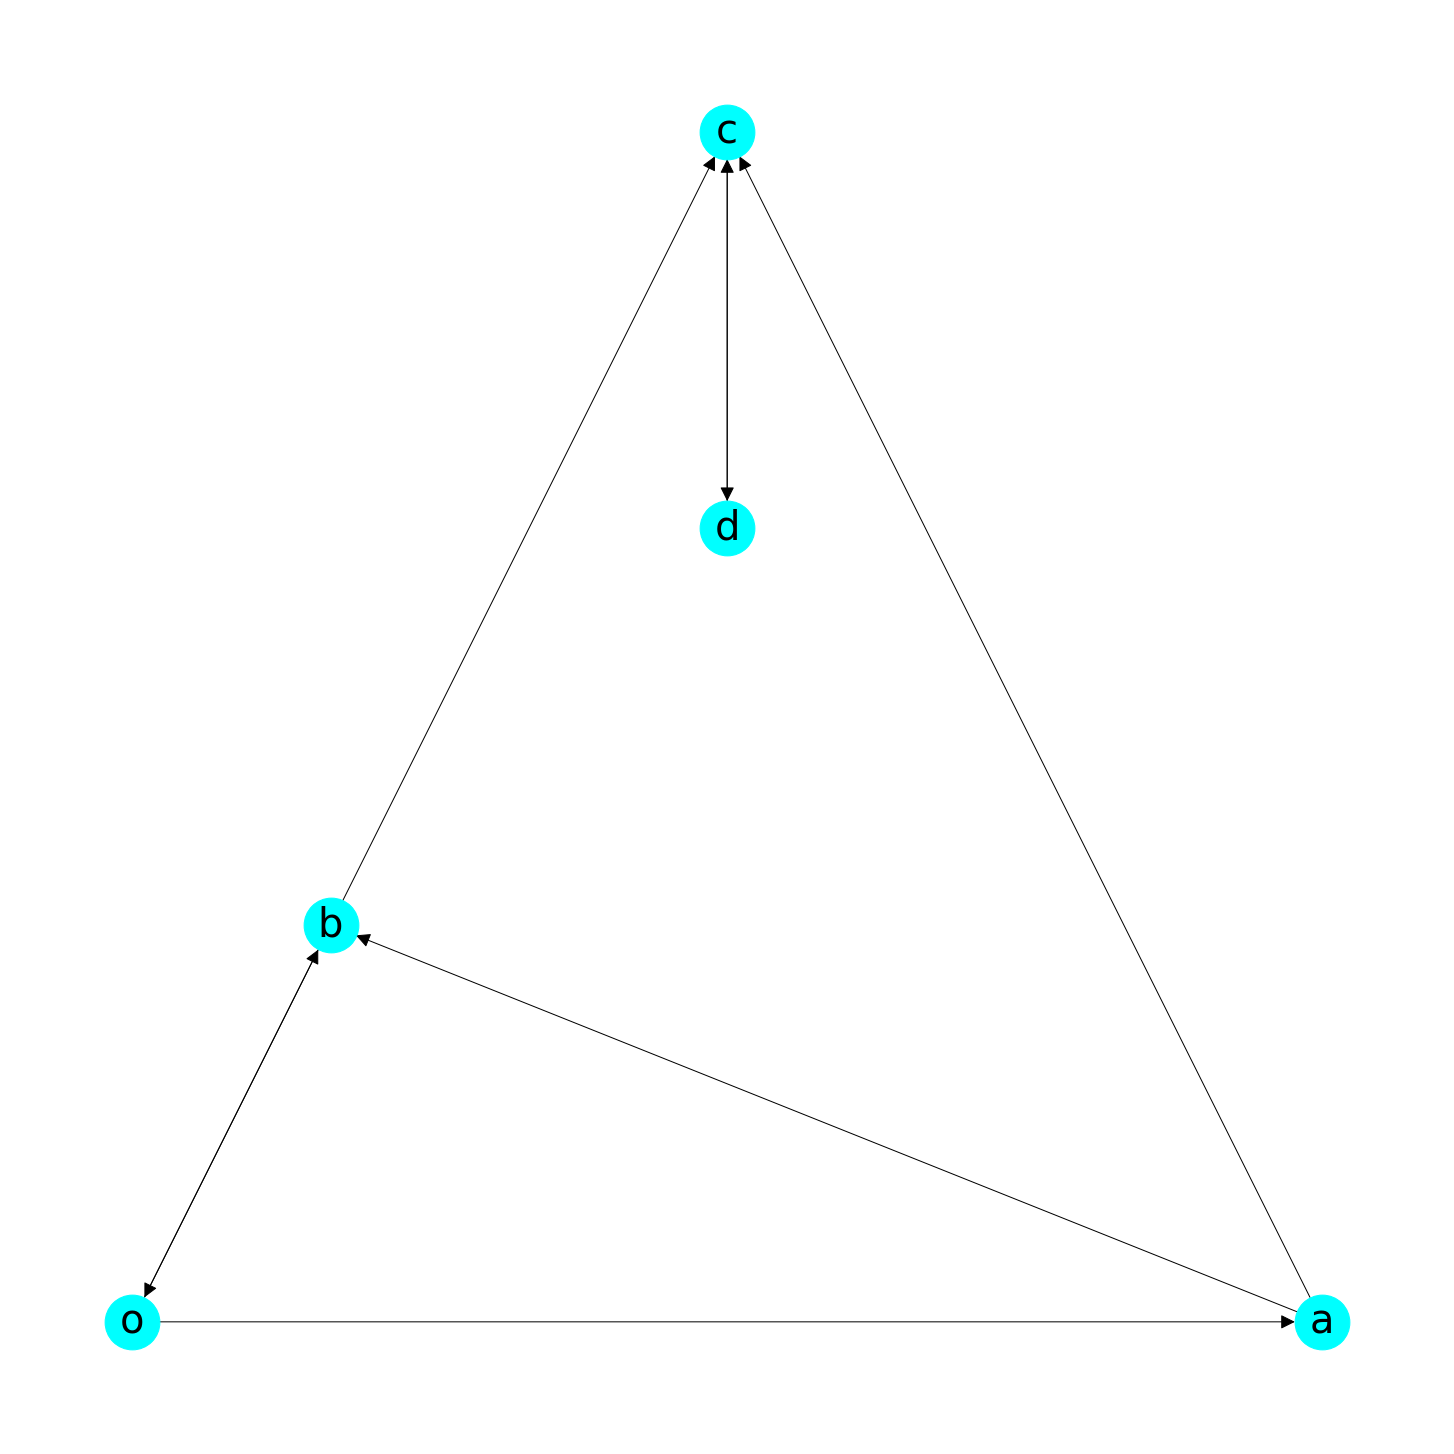

In [22]:
# Back to original graph.
G = nx.DiGraph()
G.add_weighted_edges_from([('o','a',2/5),('o','b',1/5),('a','b',3/4),('a','c',1/4),('b','o',1/2),('b','c',1/2),('c','b',1/3),('c','d',2/3),('d','a',1/3),('d','c',1/3)])

G.remove_edge('d', 'a')
G.remove_edge('c', 'b')
pos = nx.planar_layout(G)
plt.figure(figsize=(20, 20))
nx.draw(G, pos, node_color='#00ffff', arrowsize=30, node_size=3000, font_size=40, with_labels=True)

In [23]:
sorted_nodes = ['o', 'a', 'b', 'c', 'd']

# define a new graph with sorted nodes
H = nx.DiGraph()
H.add_nodes_from(sorted_nodes)
H.add_edges_from(G.edges(data=True))
print(list(H.nodes))

['o', 'a', 'b', 'c', 'd']


In [24]:
# Compute P matrix
A = nx.adjacency_matrix(H) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A

n_nodes = H.number_of_nodes()

print("Weight matrix (Lambda):\n", A)
print("P matrix:\n", P)

Weight matrix (Lambda):
 [[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.         0.         0.66666667]
 [0.         0.         0.         0.33333333 0.        ]]
P matrix:
 [[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.         0.         1.        ]
 [0.         0.         0.         1.         0.        ]]


In [25]:
n_simulation = 5
for i in range(n_simulation):
    x0 = np.random.rand(n_nodes)*3 # arbitrary initial condition
    print("x(0):", x0)
    x = x0
    t_final = 100000

    for n in range(t_final):
        x = P @ x
    print("x(" + str(t_final) + "):", x)
    print("\n")

x(0): [2.17903522 1.89686219 0.53857098 0.87863415 2.49203896]
x(100000): [1.62328252 1.56122849 2.11971477 0.87863415 2.49203896]


x(0): [2.58189678 1.6621368  2.17851959 1.85286876 2.25946916]
x(100000): [2.04053049 2.02489201 2.1656383  1.85286876 2.25946916]


x(0): [2.78934289 1.73740325 0.98892158 0.7921456  1.24743135]
x(100000): [1.00227748 0.98476649 1.1423654  0.7921456  1.24743135]


x(0): [2.8617927  1.00324797 0.6779932  1.24533058 0.73462983]
x(100000): [1.00962254 1.02926488 0.85248385 1.24533058 0.73462983]


x(0): [0.80032349 1.86609214 0.09531385 2.6143359  0.55210223]
x(100000): [1.66253575 1.74185243 1.02800231 2.6143359  0.55210223]




Condensation graph:
{0: {'members': {'d', 'c'}}, 1: {'members': {'a', 'o', 'b'}}}

0 is a sink component

1 sink component in G.


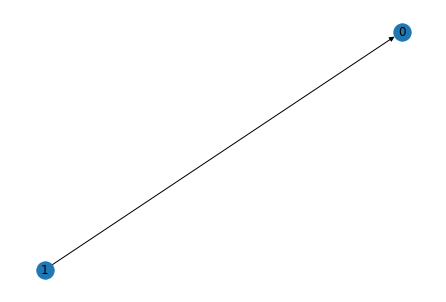

In [26]:
CG = nx.algorithms.components.condensation(H)
nx.draw(CG, with_labels=True)

print("Condensation graph:")
print(dict(CG.nodes))
print()

w = np.sum(nx.adjacency_matrix(CG).toarray(), axis=1)
sink_n = 0
for node in dict(CG.nodes):
    if w[node] == 0:
        print(node, "is a sink component")
        sink_n += 1
print()
print(sink_n, "sink component in G.")

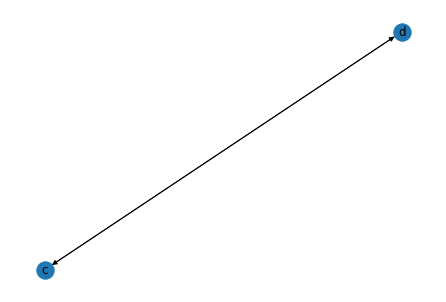

In [27]:
sink_component = list(G.subgraph(c).copy() for c in nx.algorithms.components.attracting_components(G))[0]
nx.draw(sink_component, with_labels=True)

1 sink in the condensation graph: $0$ (with nodes d)       
$\mathcal{W}_0 = \{d, c\}$.  

In [28]:
w,v = np.linalg.eig(P.T)

for i in range(len(G)):
    print(i+1)
    print("eigenvalue: ", w[i])
    print("eigenvector: ", v[i])
    print()
    
print("\nInvariant distributions pi:")
for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi/np.sum(pi) # normalization
    print("pi"+str(index+1), "=", pi)
inv_dist = pi

1
eigenvalue:  (1.0000000000000004+0j)
eigenvector:  [ 3.27642093e-16+0.j          3.20501435e-01+0.j
 -3.03133733e-01-0.39588429j -3.03133733e-01+0.39588429j
 -8.82344983e-17+0.j        ]

2
eigenvalue:  (0.7176522763383852+0j)
eigenvector:  [ 3.38175550e-16+0.j          2.97731409e-01+0.j
 -1.46871492e-01+0.54370726j -1.46871492e-01-0.54370726j
  9.54763078e-17+0.j        ]

3
eigenvalue:  (-0.35882613816919295+0.4686170351508611j)
eigenvector:  [ 7.66909906e-16+0.j  4.60017169e-01+0.j  5.88580858e-01+0.j
  5.88580858e-01-0.j -2.47100863e-16+0.j]

4
eigenvalue:  (-0.35882613816919295-0.4686170351508611j)
eigenvector:  [ 0.70710678+0.j        -0.45050362+0.j         0.11213306-0.1005088j
  0.11213306+0.1005088j -0.70710678+0.j       ]

5
eigenvalue:  (-1+0j)
eigenvector:  [ 0.70710678+0.j         -0.62774639+0.j         -0.25070869-0.04731417j
 -0.25070869+0.04731417j  0.70710678+0.j        ]


Invariant distributions pi:
pi1 = [2.31677945e-16 2.39126224e-16 5.42287195e-16 5.00000000e

$\pi_1$ is such that ${\pi_1}_i>0$ if and ony if $i \in \mathcal{W}_0$.

In [29]:
sink_component = list(G.subgraph(c).copy() for c in nx.algorithms.components.attracting_components(G))[0]
print("Is the sink component aperiodic?:",nx.is_aperiodic(sink_component))

Is the sink component aperiodic?: False


The sink component of the condensation graph: $0$ is not aperiodic

- The condensation graph of $\mathcal{G}$ has 1 sink
- the sink component of the graph not is aperiodic,

Since the sink component is not aperiodic, the dynamics does not converges to a consensous state.

In addition,    
let $\lambda:=\max \{\lambda_2,|\lambda_n|\}$, where $\lambda_1 \ge \lambda_2 \ge \cdots \ge \lambda_n$ are the eigenvalues of $P$.

Since $\lambda_n = -1$ (thus $\lambda=1$), then the convergence to consensus is not achieved.

In particular:

x(0): [1.44974718 2.40621957 1.33264282 2.79873966 2.24595881]
	Theorical consensous value: 2.5223492384595043
x(1): [2.04836066 1.69916703 2.12424342 2.24595881 2.79873966]
x(2): [1.84085916 2.15467227 2.14715974 2.79873966 2.24595881]
x(3): [2.15216809 2.31005472 2.31979941 2.24595881 2.79873966]
x(4): [2.31330295 2.30133926 2.19906345 2.79873966 2.24595881]
x(5): [2.26724733 2.34898251 2.55602131 2.24595881 2.79873966]
x(6): [2.41799544 2.47850568 2.25660307 2.79873966 2.24595881]
x(7): [2.40453815 2.39213722 2.60836755 2.24595881 2.79873966]
x(8): [2.464214   2.51776537 2.32524848 2.79873966 2.24595881]
x(9): [2.45359307 2.44362128 2.63147683 2.24595881 2.79873966]
x(10): [2.50623979 2.53509733 2.34977594 2.79873966 2.24595881]
x(11): [2.47332353 2.46201687 2.65248973 2.24595881 2.79873966]
x(12): [2.52550782 2.550857   2.35964117 2.79873966 2.24595881]
x(13): [2.48711839 2.4694158  2.66212374 2.24595881 2.79873966]
x(14): [2.53365178 2.55808251 2.3665386  2.79873966 2.24595881]
x(

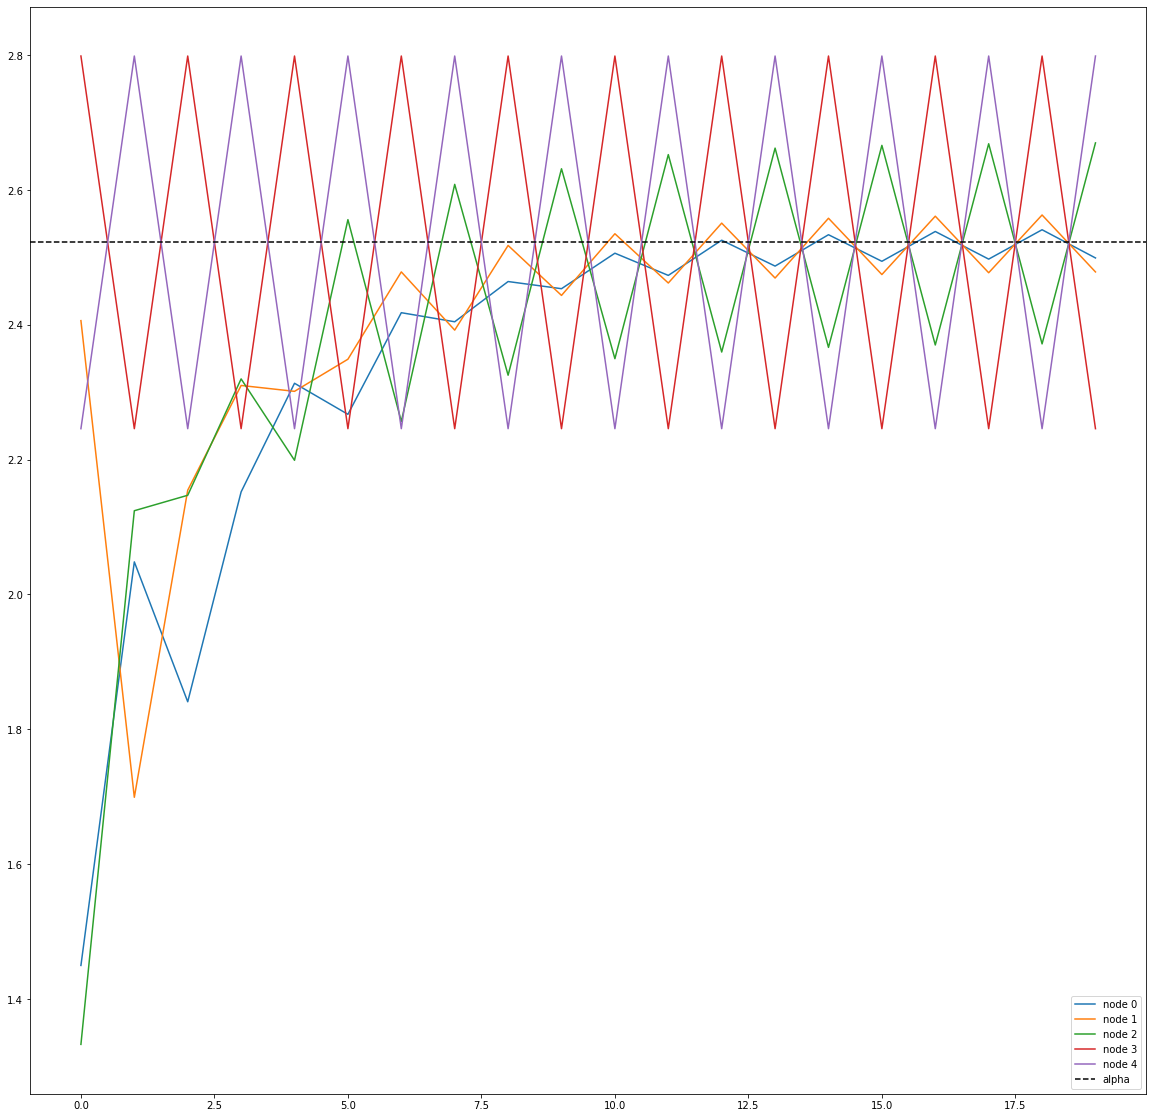

In [36]:
t_final = 100
x = np.zeros((n_nodes,t_final+1))
x0 = np.random.rand(n_nodes)*3 # arbitrary initial condition
x[:,0] = x0
print("x(0):", x0)
print("\tTheorical consensous value:", inv_dist@x0)

for n in range(1, t_final+1):
    x[:,n] = P @ x[:,n-1]
    print("x(" + str(n) + "):", x[:,n])
    
fig = plt.figure(1, figsize=(20,20))
ax = plt.subplot(111)

for node in range(n_nodes):
    trajectory = x[node,0:20]
    ax.plot(trajectory, label='node {0:d}'.format(node))
ax.axhline(y = inv_dist@x0, color = 'black', linestyle = '--', label='alpha')    
ax.legend()

y = x[:,99]
y_succ = x[:,100]
y_avg = (y+y_succ)/2 # average value between 2 consective in time states
print("Is the average value between x(t) and x(t-1) equals to the theorical consensous value?", sum(np.isclose(y_avg, inv_dist@x0))==len(y_avg))

Whatever initial condition $x(0)$ is chosen, after a small number of time instants, the state of each node oscillates in 2 consecutive time istants between 2 values and continues to oscillate up to infinity.      
The teorical consensous value (to which each node would converge if the sink component would not be periodic) can be computed as before as:
$$
\alpha = \pi' x(0)
$$
Since $\pi$ such that $\pi_i \neq 0$ only if $i \in \{3,4\}$ (nodes belonging to the sink component) and $\pi_3 = \pi_4 = \frac{1}{2}$, $\alpha$ is equals to the mean between the initial state of nodes $3$ and $4$.    
The state of each node oscillates between 2 values whose average is $\alpha$.   
In particular:
- The state of nodes $3$ and $4$ oscillates between their initial values
- The state of nodes $0,1,2$ oscillates between values close to $\alpha$. The amplitude of the oscillation depends on the initial states and it is, in general higher for node $2$.    

For istance, in the example above, $\alpha = 2.522$. Node $4$ state oscillate between $2.246$ (its initial state) and $2.799$ (node $4$ initial state) and the same happen for node $3$, starting from its initial state. Node $0$ state, starting from $1.5$, oscillates, after some time istants, between $2.501$ and $2.544$. Node $1$ state, starting from $2.406$, oscillates, after some time istants, between $2.480$ and $2.565$. Node $2$ state, starting from $1.333$, oscillates, after some time istants, between $2.374$ and $2.671$. 

x(0): [1.24177077 0.88083804 1.30815481 0.96410601 0.96410601]
	Theorical consensous value: 0.9641060103623638
x(1): [1.02327696 1.22214261 1.10293839 0.96410601 0.96410601]
x(2): [1.18240787 1.06823029 0.99369149 0.96410601 0.96410601]
x(3): [1.04338403 0.98629512 1.07325694 0.96410601 0.96410601]
x(4): [1.01528239 1.04596921 1.00374502 0.96410601 0.96410601]
x(5): [1.03189448 0.99383527 0.9896942  0.96410601 0.96410601]
x(6): [0.99245491 0.98329715 0.99800024 0.96410601 0.96410601]
x(7): [0.98819818 0.98952669 0.97828046 0.96410601 0.96410601]
x(8): [0.98577794 0.97473685 0.9761521  0.96410601 0.96410601]
x(9): [0.9752086  0.97314058 0.97494198 0.96410601 0.96410601]
x(10): [0.97374104 0.97223299 0.9696573  0.96410601 0.96410601]
x(11): [0.97137443 0.96826948 0.96892353 0.96410601 0.96410601]
x(12): [0.9684875  0.96771915 0.96774022 0.96410601 0.96410601]
x(13): [0.96772617 0.96683167 0.96629675 0.96410601 0.96410601]
x(14): [0.96665336 0.96574907 0.96591609 0.96410601 0.96410601]
x(

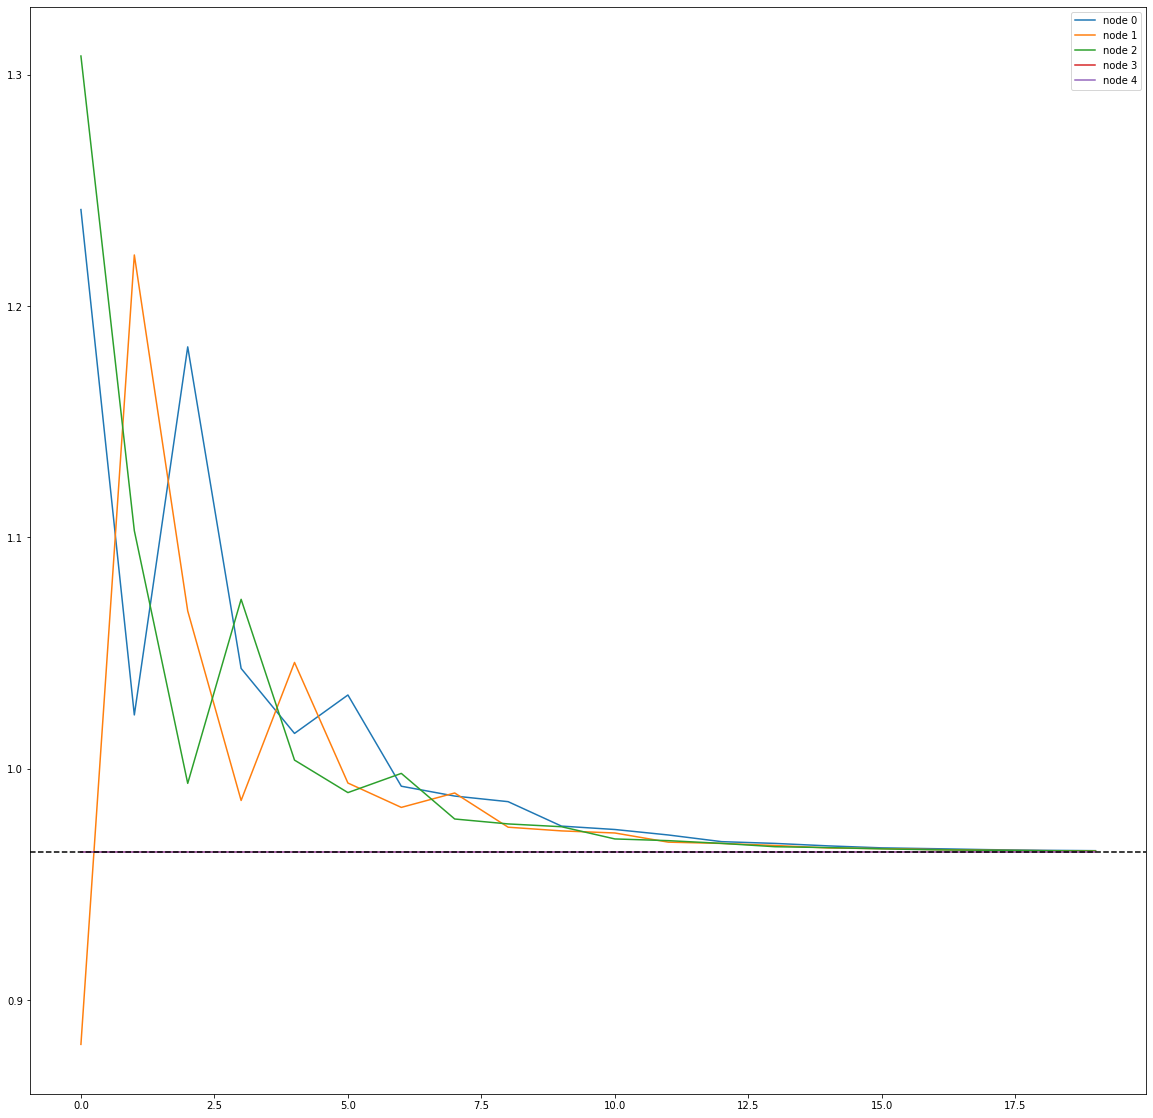

In [29]:
t_final = 100
x = np.zeros((n_nodes,t_final+1))
x0 = np.random.rand(n_nodes)*3 # arbitrary initial condition
x0[4] = x0[3] # nodes belonging to the sink periodic component have the same initial state
x[:,0] = x0
print("x(0):", x0)
print("\tTheorical consensous value:", inv_dist@x0)

for n in range(1, t_final+1):
    x[:,n] = P @ x[:,n-1]
    print("x(" + str(n) + "):", x[:,n])
    
fig = plt.figure(1, figsize=(20,20))
ax = plt.subplot(111)

for node in range(n_nodes):
    trajectory = x[node,0:20]
    ax.plot(trajectory, label='node {0:d}'.format(node))
ax.axhline(y = inv_dist@x0, color = 'black', linestyle = '--')    
ax.legend()


y_final = x[:,100]
print("Does x(t) tend to the theorical consensous value?", sum(np.isclose(y_final, inv_dist@x0))==len(y_avg))

If the initial condition $x(0)$ is chosen such that nodes belonging to the periodic sink component (i.e., nodes $3$ and $4$) have the same initial condition the state nodes converges to consensous value $\alpha$   
$$
\alpha = \pi' x(0) = x_3(0) = x_4(0)
$$
since $\pi_3 = \pi_4 = \frac{1}{2}$


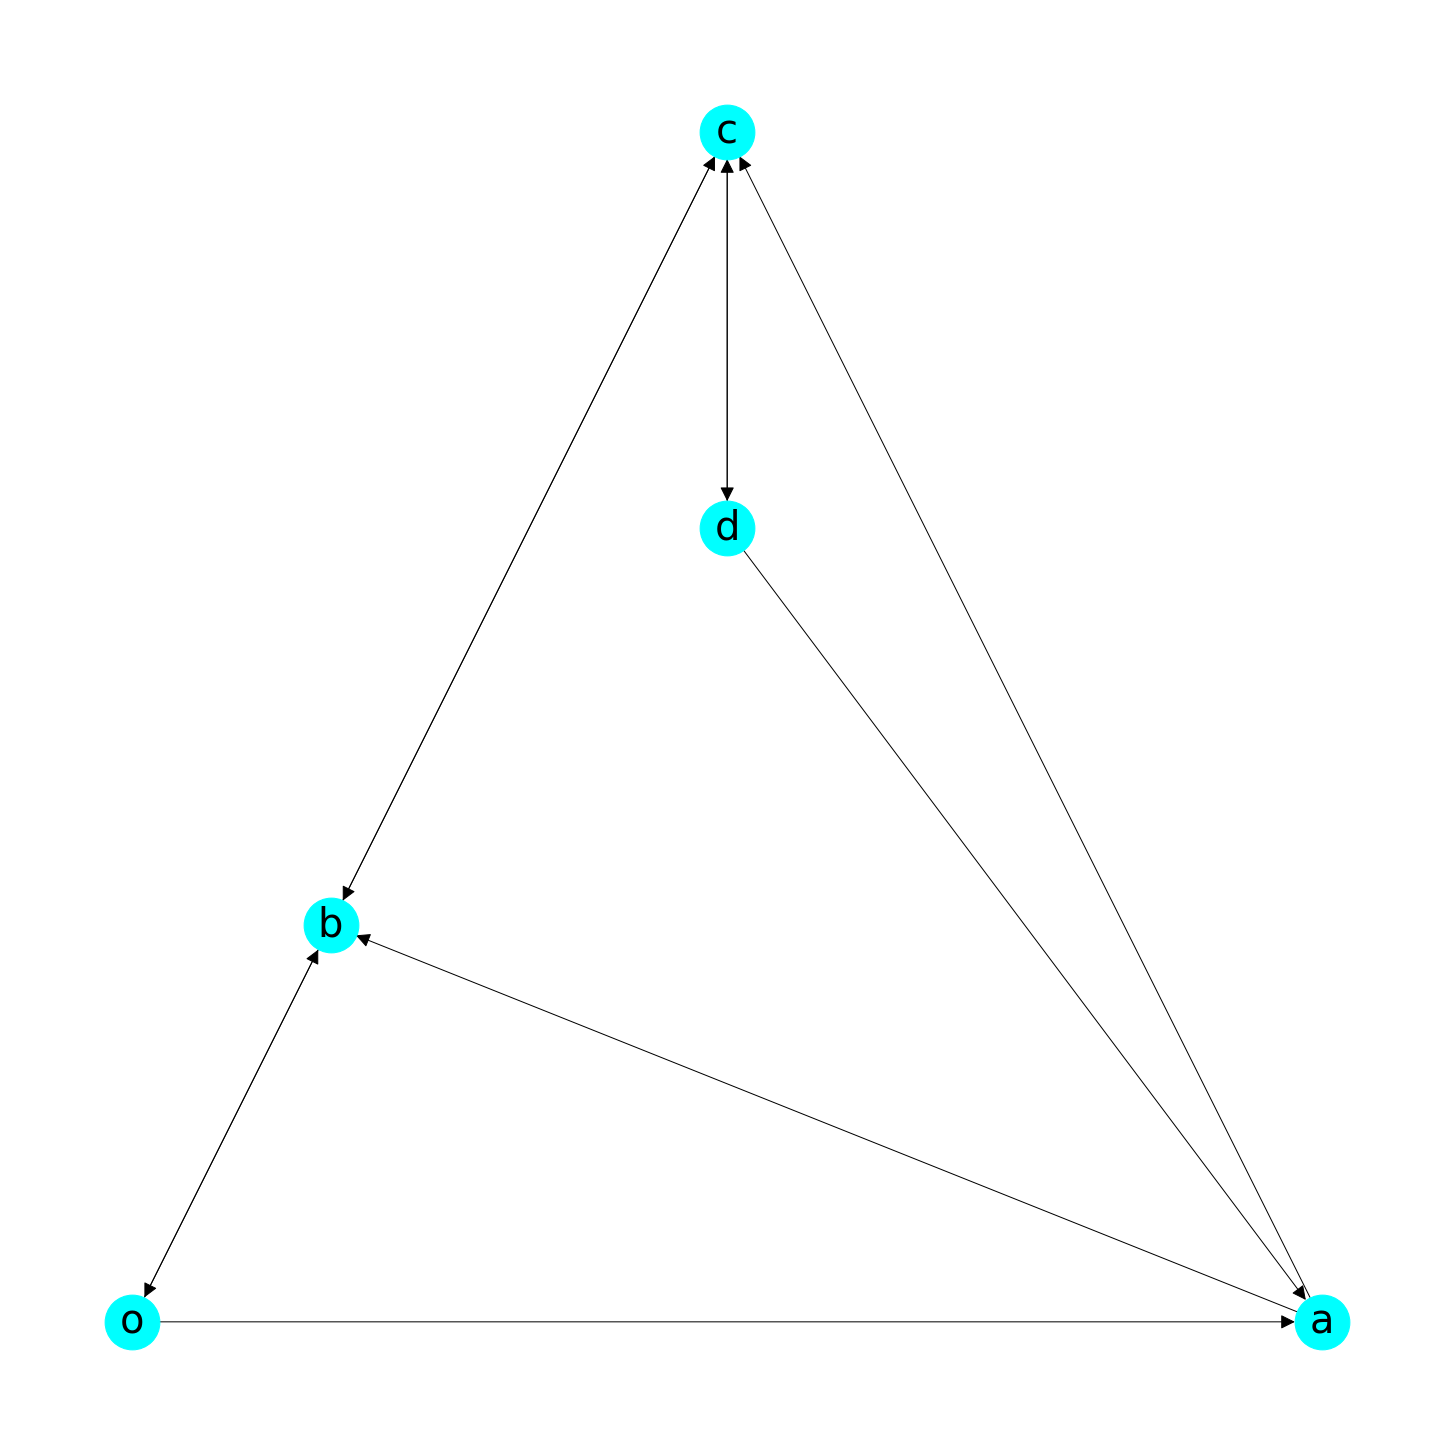

In [30]:
G = nx.DiGraph()
G.add_edges_from([('o','a'),('o','b'),('a','b'),('a','c'),('b','o'),('b','c'),('c','b'),('c','d'),('d','a'),('d','c')])

pos = nx.planar_layout(G)
plt.figure(figsize=(20, 20))
nx.draw(G, pos, node_color='#00ffff', arrowsize=30, node_size=3000, font_size=40, with_labels=True)

In [31]:
sorted_nodes = ['o', 'a', 'b', 'c', 'd']

# define a new graph with sorted nodes
H = nx.DiGraph()
H.add_nodes_from(sorted_nodes)
H.add_edges_from(G.edges(data=True))
print(list(H.nodes))

['o', 'a', 'b', 'c', 'd']


In [32]:
Lambda = [
[0, 2/5, 1/5, 0, 0],
[0, 0, 3/4, 1/4, 0],
[1/2, 0, 0, 1/2, 0],
[0, 0, 1/3, 0, 2/3],
[0, 1/3, 0, 1/3, 0]]

print("Lambda matrix: \n", np.array(Lambda))

Lambda matrix: 
 [[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.        ]]


In [33]:
w = np.sum(Lambda, axis=1)
w_star = np.max(w)

print("w vector: \n", w)
P_bar = Lambda/w_star # off-diagonal part of P_bar
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1)) # diagonal part of P_bar
print("P_bar matrix: \n", P_bar)

w vector: 
 [0.6        1.         1.         1.         0.66666667]
P_bar matrix: 
 [[0.4        0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.33333333]]


Particle perspective

In [39]:
# Simulates a random walk of 'n_particles' particles on a weighted graph, according to transition probability matrix P_bar (P), starting from node 'start'.
# The random walk goes on for num_steps steps.


# It returns a tuple(particles, general_transition_times, pos_part, t_next) such that:
# particles stores the particle ids
# general_transition_times stores the time instants at which transitions happen indipendently from the particle
# pos_part is a dictionary:
#     each key represents a particle (identified by 'particle' elements)
#     each value is a tuple(pos, pos_names, transition_times)
#         pos and pos_names keep trace of the visited states: pos refers to their position in 'nodes_list', pos_names to their name stored in elements of 'nodes_list'
#         transition_times stores the time instants at which transitions happen
# t_next stores the last waiting time, useful to compute: transition_times[-1] + t_next, end of the time horizon.
def RandomWalk_NotUniformTransitionProbability__multipleParticles(P, n_particles, w, nodes_list, start, num_steps = 1000000):
    nstates = P.shape[0]
    
    particles = np.arange(n_particles) # particle ids
    # pos_part keep trace of the visited states and the transition times, for each particle
    pos_part = {}
    for par in particles: # particle id: par
        pos = np.zeros(num_steps, dtype=int) # pos keep trace of the visited states for the particle 
        pos[0] = nodes_list.index(start)
        transition_times = np.zeros(num_steps) # transition_times store the time instants at which transitions happen for the particle
        size = 1 # current size of pos and transition_times
        pos_part[par] = (pos, transition_times, [size])

    w_star = np.max(w)
    t_next = -np.log(np.random.rand())/n_particles
    # System-wide Poisson clock with rate n_particles.
        
    # transition_times store the time instants at which transitions happen
    general_transition_times = np.zeros(num_steps) # general_transition_times store the time instants at which transitions happen indipendently from the particle
    
    
    for i in range(1, num_steps):
        particle_selected = np.random.choice(particles) # randomly select which particle to move
        # pos_part[particle_selected][0] stores the positions of the specific particle
        # pos_part[particle_selected][1] stores the transition times of the specific particle
        # pos_part[particle_selected][2] stores the current size of the vectors 
        # the next state to visit will be extracted according to the probabilities stored in the row of T corresponding to the current state.
        size = pos_part[particle_selected][2][0]
        pos_part[particle_selected][0][size] = np.random.choice(nstates, p=P[pos_part[particle_selected][0][size-1],:])
        pos_part[particle_selected][1][size] = general_transition_times[i-1] + t_next
        pos_part[particle_selected][2][0] += 1
 
        general_transition_times[i] = general_transition_times[i-1] + t_next
    
        t_next = -np.log(np.random.rand())/n_particles # waiting time to the next transition
        # System-wide Poisson clock with rate n_particles.

    for par in particles:
        pos = pos_part[par][0]
        transition_times = pos_part[par][1]
        size = pos_part[par][2][0]
        transition_times.resize(size, refcheck=False) # resize vector to actual size
        pos.resize(size, refcheck=False) # resize vector to actual size
        pos_names = [nodes_list[i] for i in pos] # map pos to node names
        pos_part[par] = (pos, pos_names, transition_times)
    
    return (particles, general_transition_times, pos_part, t_next)

In [40]:
n_particles = 100
particles, general_transition_times, pos_part, t_next = RandomWalk_NotUniformTransitionProbability__multipleParticles(P_bar, n_particles, w, sorted_nodes, 'o', num_steps=10000)

Time istants:
[0.00000000e+00 1.35505823e-03 2.03676313e-03 1.12214196e-02
 1.65316320e-02 1.83520883e-02 2.84814842e-02 3.97008792e-02
 4.93440546e-02 6.28632356e-02 7.38860843e-02 8.99912560e-02
 1.09853026e-01 1.26957111e-01 1.36784982e-01 1.46304852e-01
 1.47783539e-01 1.57860038e-01 1.70515489e-01 1.73025091e-01
 1.73615014e-01 1.76951165e-01 1.92769509e-01 1.97867015e-01
 1.98127777e-01 2.00409060e-01 2.03130544e-01 2.04485986e-01
 2.06906527e-01 2.10083451e-01 2.10196111e-01 2.19153170e-01
 2.20563059e-01 2.28536747e-01 2.37034470e-01 2.47335558e-01
 2.63686663e-01 2.65680962e-01 2.79509885e-01 2.90634642e-01
 2.98039423e-01 3.03960586e-01 3.05485190e-01 3.14415405e-01
 3.16020206e-01 3.26140449e-01 3.29878698e-01 3.40234490e-01
 3.45202541e-01 3.48146399e-01 3.58460102e-01 3.59056494e-01
 3.61336827e-01 3.97718749e-01 4.02461820e-01 4.03264794e-01
 4.03746102e-01 4.07354538e-01 4.19979710e-01 4.31891137e-01
 4.70583470e-01 4.83432963e-01 5.28200746e-01 5.52785945e-01
 5.6248107

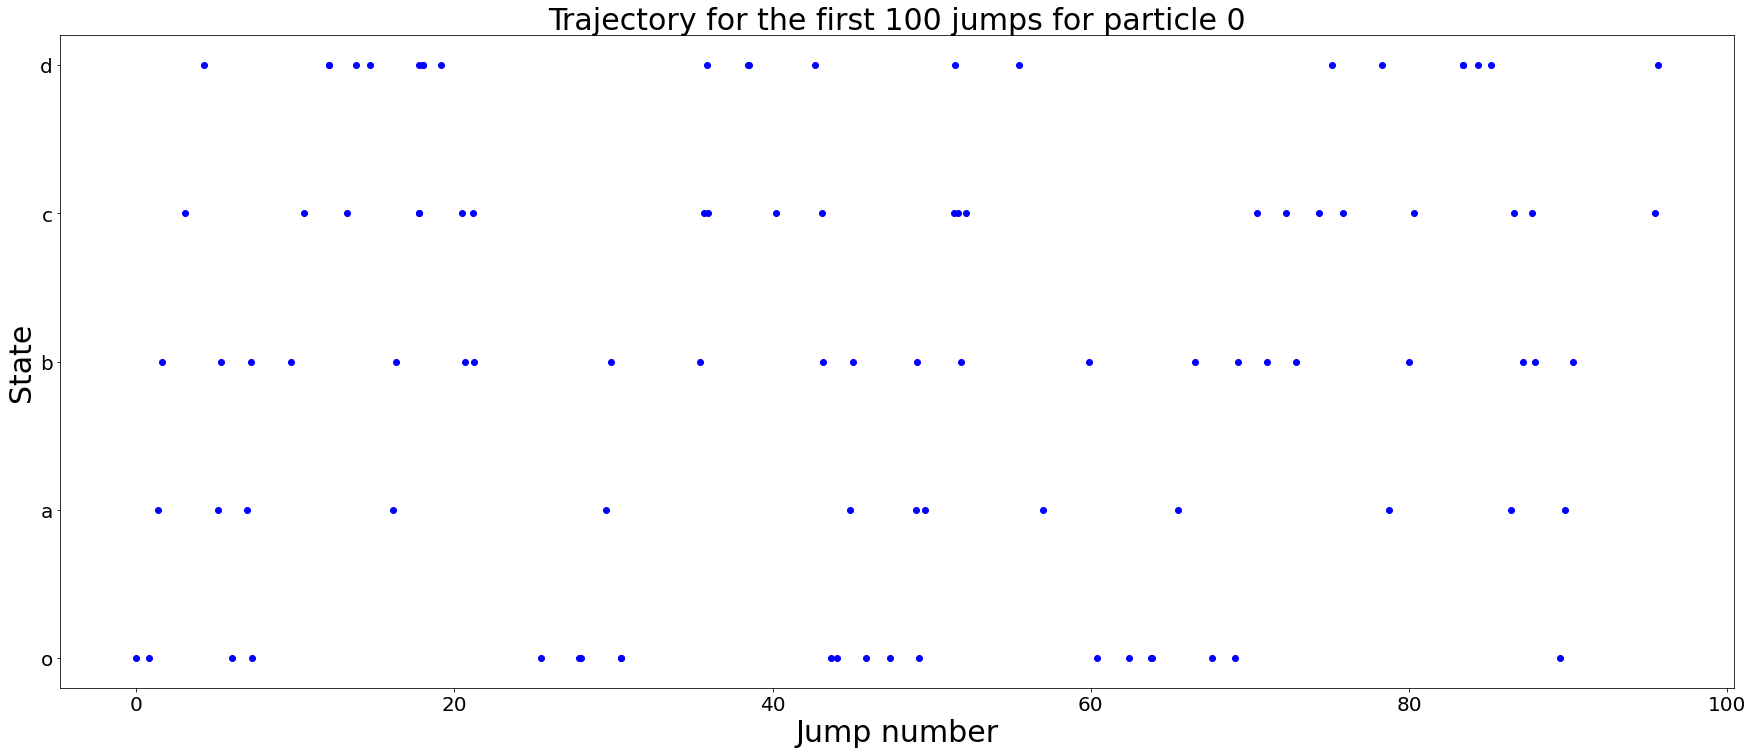

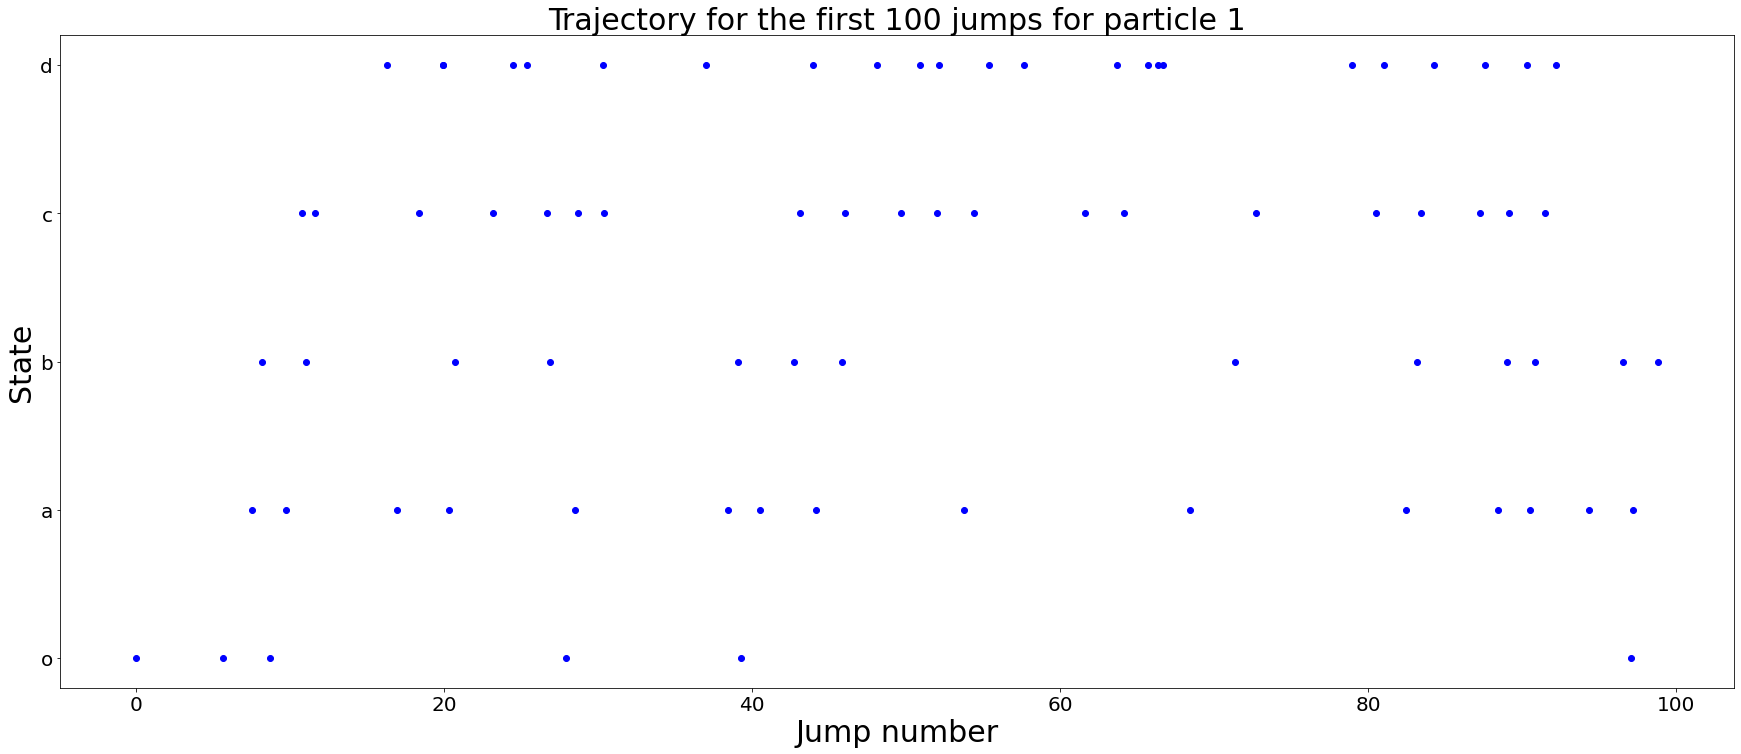

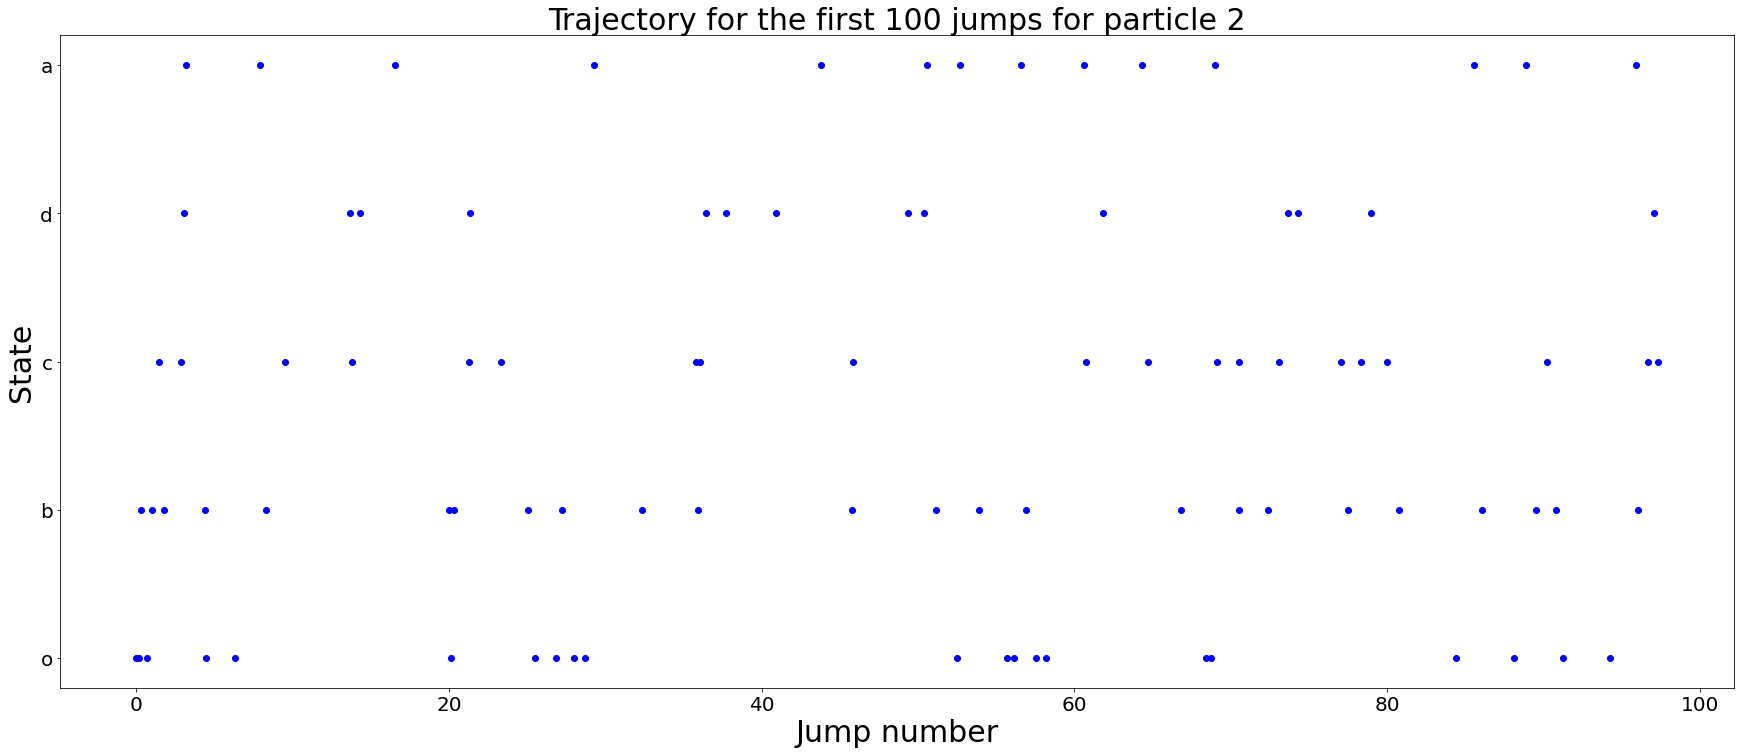

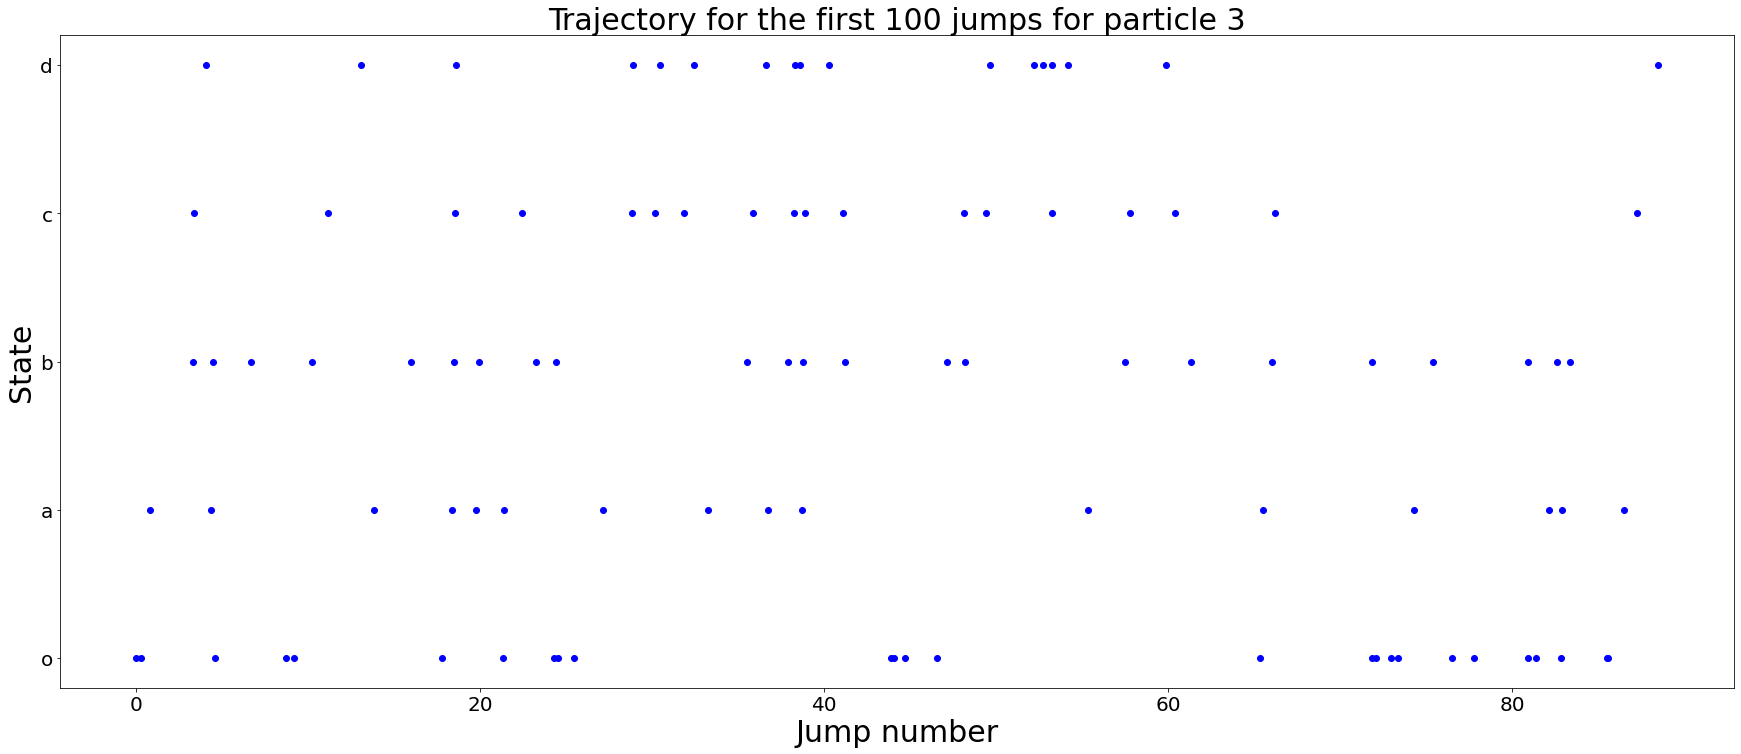

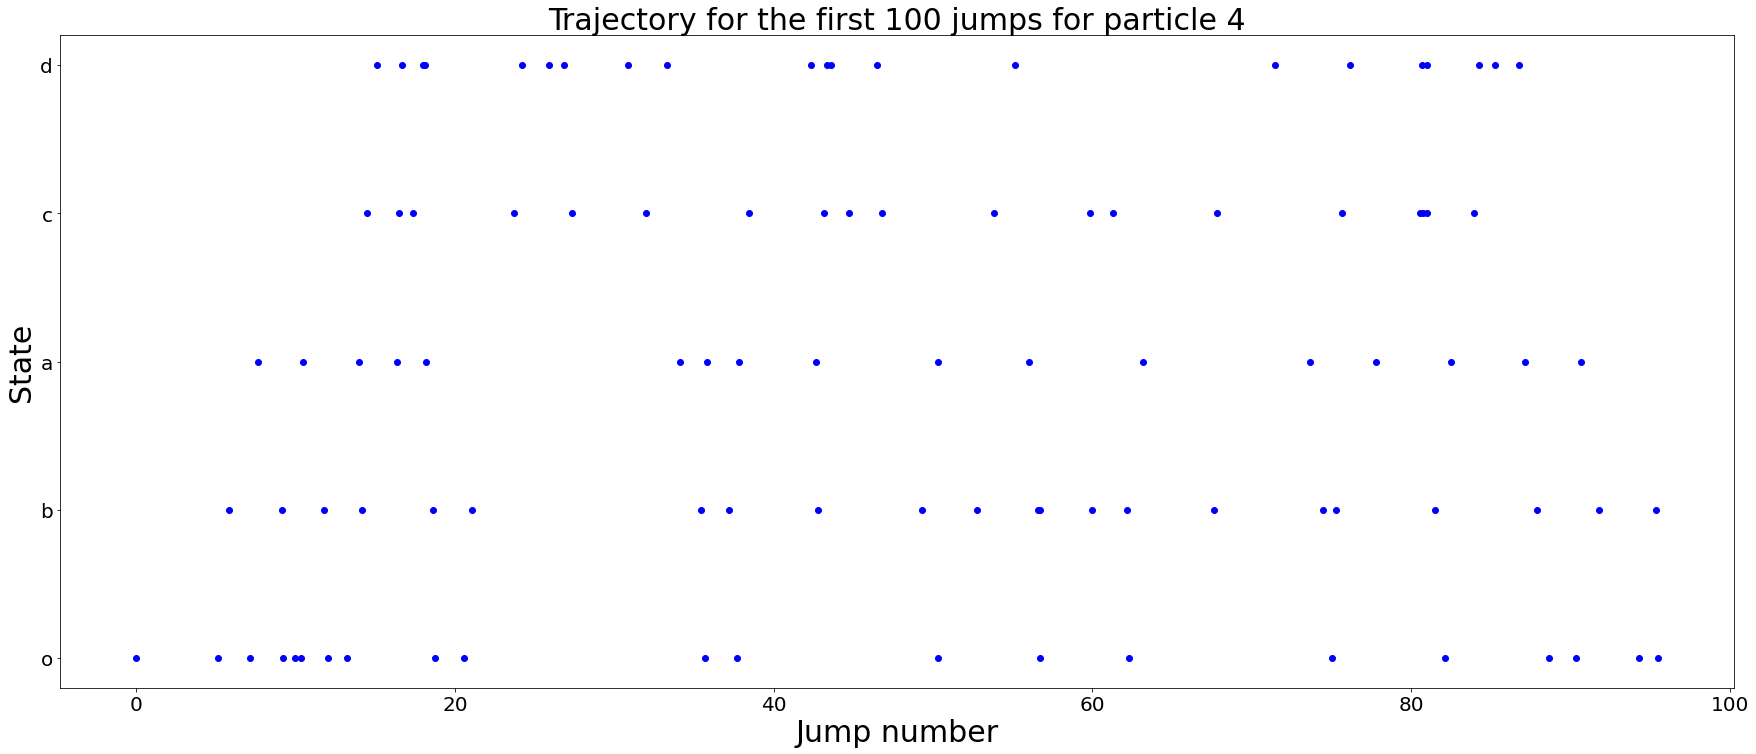

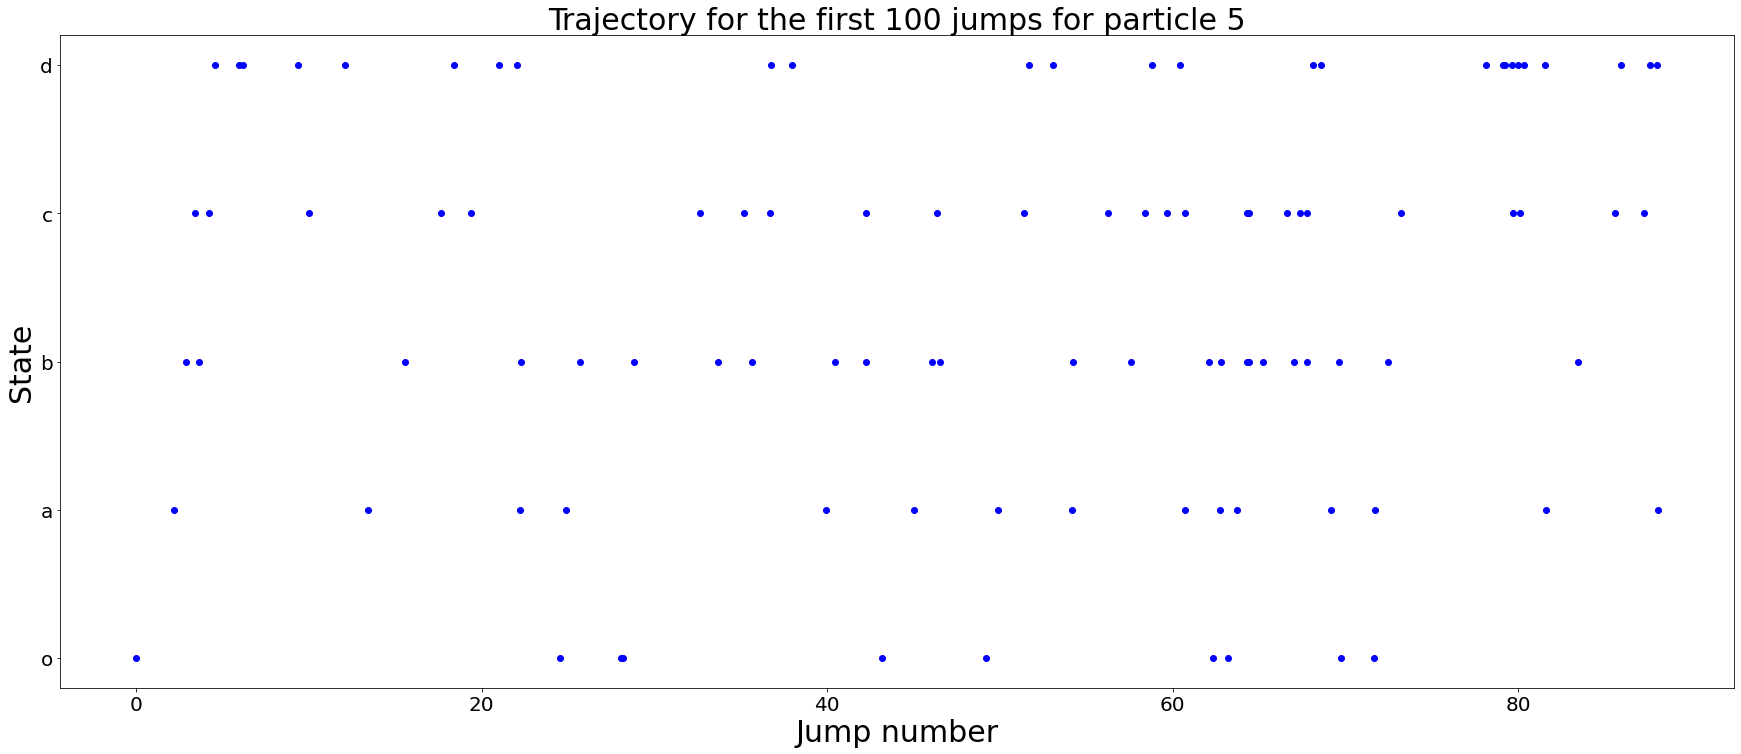

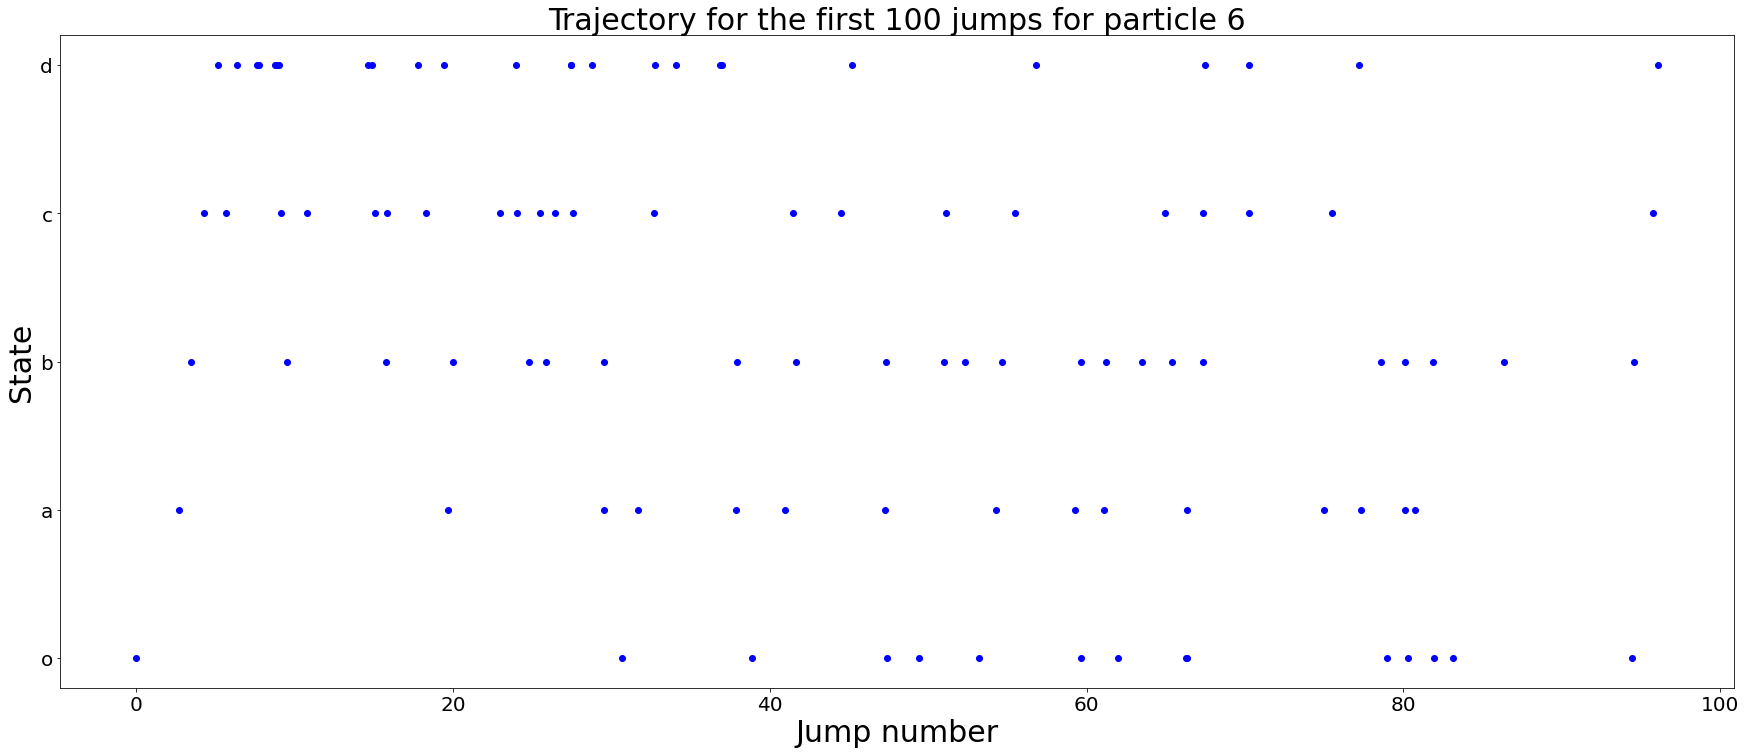

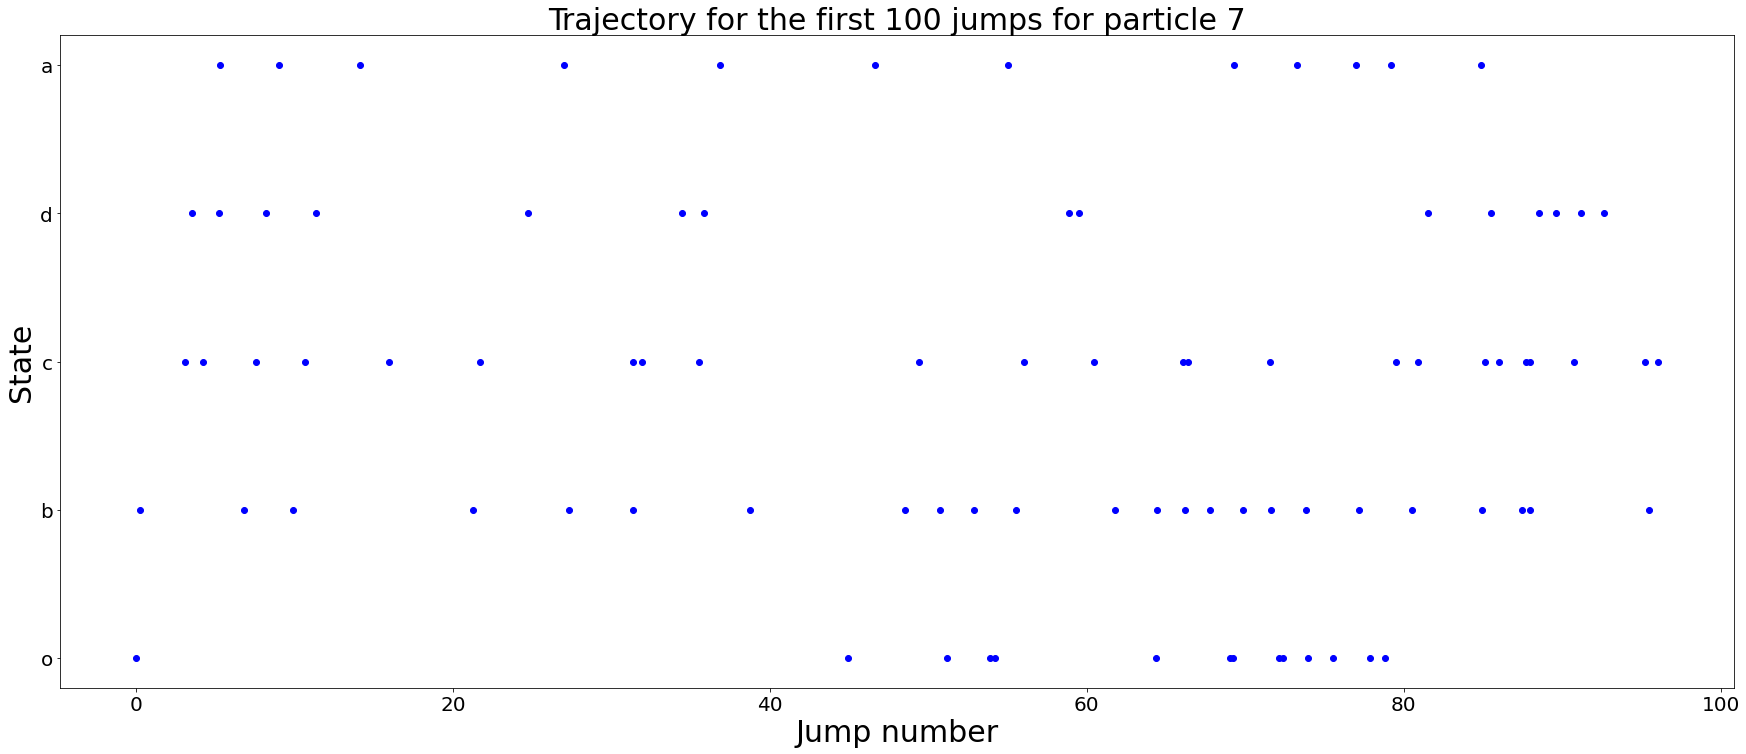

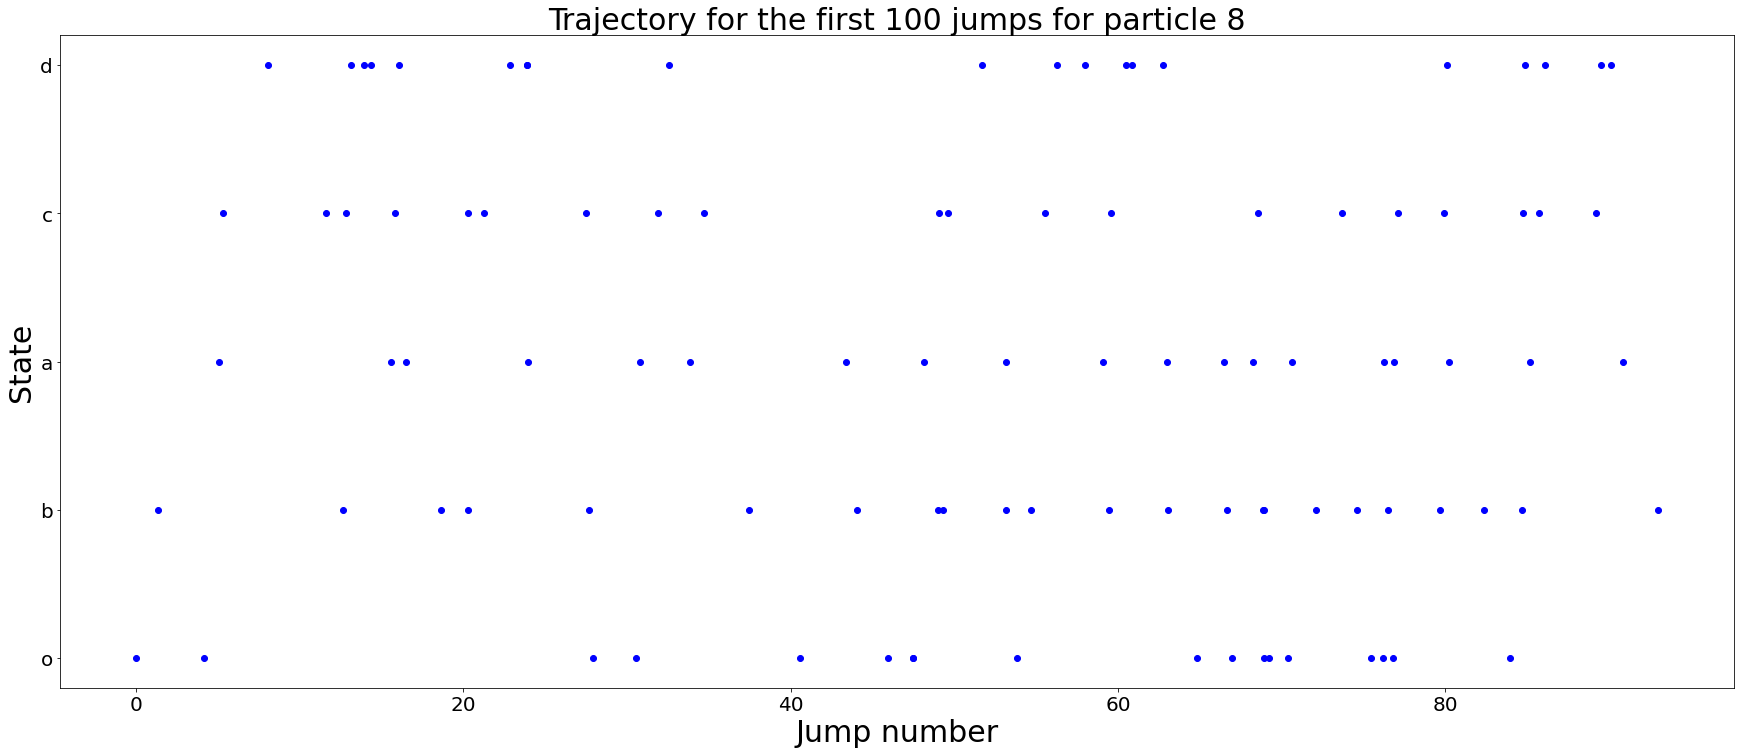

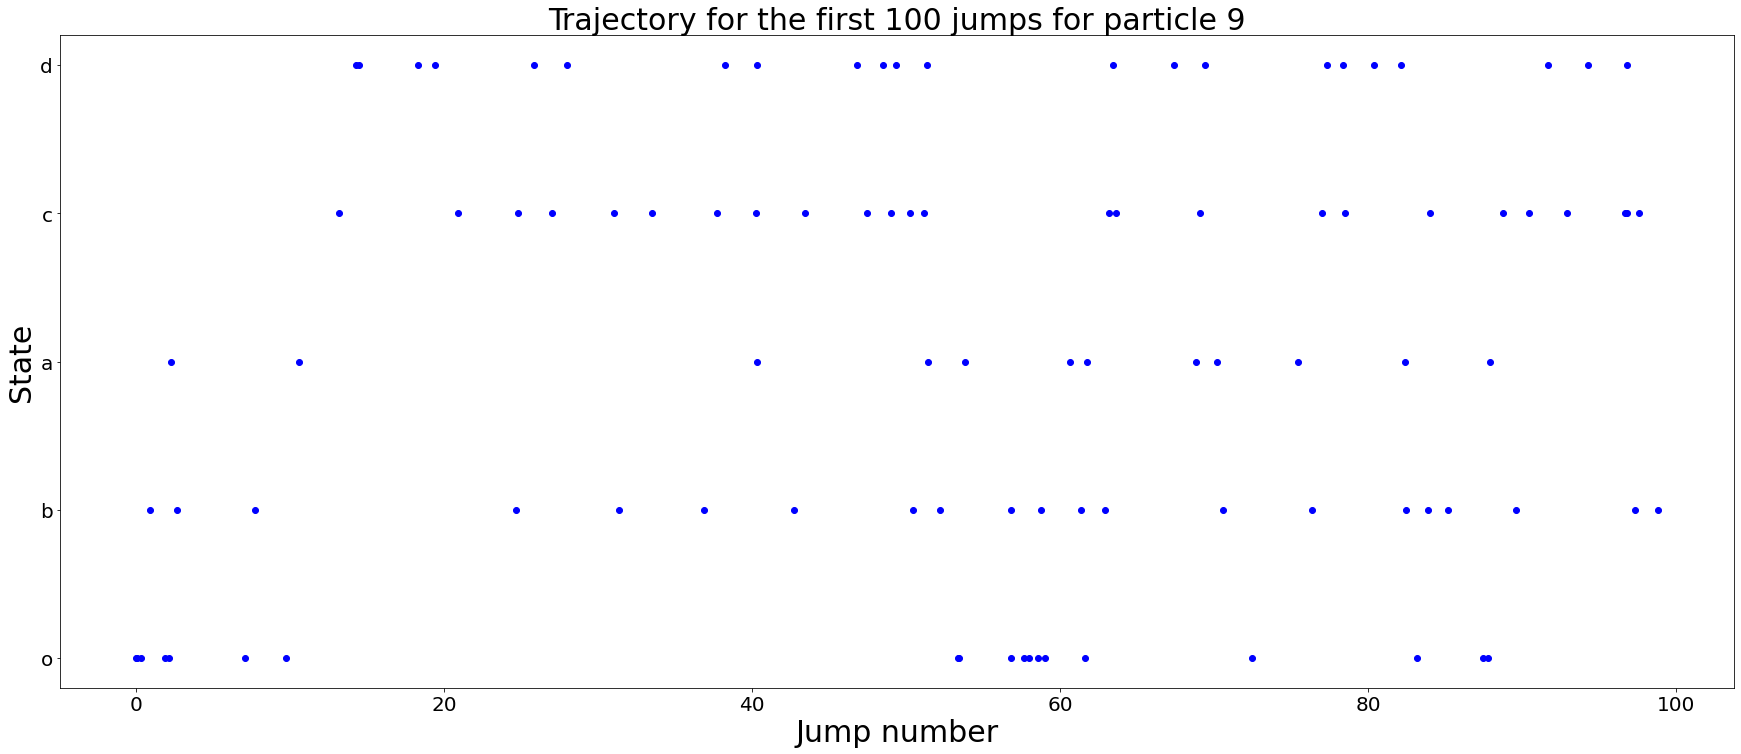

In [41]:
for i in particles[:10]: #first 10 particles
    part = pos_part[i]
    pos = part[0]
    pos_names = part[1]
    transition_times = part[2]
    # plot the trajectory for the first 100 jumps
    plt.figure(figsize=(30, 12))
    plt.plot(transition_times[0:100], pos_names[0:100], 'bo')
    plt.title('Trajectory for the first 100 jumps for particle ' + str(i), fontsize = 30)
    plt.xlabel('Jump number', fontsize = 30)
    plt.ylabel('State', fontsize = 30)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)

# print time instants at which transitions happen indipendently from the particle (first 200 time istants)
print("Time istants:")
print(general_transition_times[0:200])

In [9]:
def second_match(l, val): # get the second element of a list matching condition: element == val
    count = 0
    for i in range(len(l)):
        if l[i] == val:
            count += 1
        if count == 2:
            return i

#n_simul = 1000000
n_simul = 10000
n_particles = 100
start = 'a'
coll_t = np.zeros(n_simul)
for j in range(0, n_simul):
    particles, general_transition_times, pos_part, t_next = RandomWalk_NotUniformTransitionProbability__multipleParticles(P_bar, n_particles, w, sorted_nodes, start, num_steps=10000)
    times = np.zeros(len(particles))
    for i in particles:
        part = pos_part[i]
        pos_names = part[1]
        transition_times = part[2]
        # get the index of the second (first is starting node) occurence of start in pos_names
        index = second_match(pos_names, start)
        # use the index to get the corresponding time istant
        time = transition_times[index]
        times[i] = time
    time_avgpart = times.mean()
    coll_t[j] = time_avgpart
avg_t = coll_t.mean()

print("Average time for a particle to leave a and then return to a (if all particles starts in a):", avg_t)

Average time for a particle to leave a and then return to a (if all particles starts in a): 6.745644928620706


In [13]:
onePart_time = r_time # time computed previously with only one particle
multiPart_time = avg_t # time computed with 100 particels

print("Time computed with only one particle =", onePart_time, "\n")

print("Time computed with 100 particels =", multiPart_time, "\n")

error = abs(onePart_time-multiPart_time)
print("Comparison: ", error)

Time computed with only one particle = 6.75 

Time computed with 100 particels = 6.745644928620706 

Comparison:  0.004355071379293918


The 2 times computed are close each other.   
This can be esplained taking into account the following consideration.    
With only 1 particle, the time a particle has to wait for the next transition (which can also lead to the same node) is a random variable with exponential distribution with rate $w_* = 1$.    
With only 1 particle, the time a general particle has to wait for the next transition (which can also lead to the same node) is a random variable with exponential distribution with rate $n$, where $n$ is the number of particles.   However, a single specific particle has a probability of being extracted as particle which will make the transition equals $1/n$


Node perspective

In [44]:
# Simulates a random walk of 'n_particles' particles on a weighted graph, according to transition probability matrix P_bar (P), starting from node 'start'.
# The random walk goes on for num_steps steps or for the first final_time final units. The termination condition can be expressed through the parameter stop, which can be set to 'final_time' or 'num_steps'


# It returns a tuple(transition_times, nodes_part, t_next) such that:
# transition_times stores the time instants at which transitions happen
# nodes_part is a matrix whose rows i represent the i-th time istants in vector transition_times and whose columns j represent the number of particles in each node 
# t_next stores the last waiting time, useful to compute: transition_times[-1] + t_next, end of the time horizon.
def RandomWalk_NotUniformTransitionProbability__nodePerspective(P, n_particles, w, nodes_list, start, num_steps = 1000000, final_time = 60, stop = 'num_steps'):
    nstates = P.shape[0]
    
    nodes_part = np.zeros((num_steps, nstates)) # nodes_part keep trace of the number of particles in each node at each time istant    
    transition_times = np.zeros(num_steps) # transition_times store the time instants at which transitions happen for the particle
    size = num_steps
    
    nodes_part[0,nodes_list.index(start)] = n_particles
    
    w_star = np.max(w)
    t_next = -np.log(np.random.rand())/n_particles
    # System-wide Poisson clock with rate n_particles.
    
    if stop == 'num_steps':
        for i in range(1, num_steps):
            node_selected = np.random.choice(nstates, p=nodes_part[i-1,:]/n_particles) # randomly select a node from which move a particle
        
            node_toMove = np.random.choice(nstates, p=P[node_selected,:])
            nodes_part[i,:] = nodes_part[i-1,:]
        
            #update node from which a particle has been moved and node to which it has been moved
            nodes_part[i,node_selected] -= 1
            nodes_part[i,node_toMove] += 1
            transition_times[i] = transition_times[i-1] + t_next
    
            t_next = -np.log(np.random.rand())/n_particles # waiting time to the next transition
            # System-wide Poisson clock with rate n_particles.
            
    if stop == 'final_time':
        maxt = 0
        i = 1
        while maxt<=final_time:
            if i==size:
                size = size*2
                transition_times.resize(size, refcheck=False)
                nodes_part.resize((size,n_states), refcheck=False)
            node_selected = np.random.choice(nstates, p=nodes_part[i-1,:]/n_particles) # randomly select a node from which move a particle
        
            node_toMove = np.random.choice(nstates, p=P[node_selected,:])
            nodes_part[i,:] = nodes_part[i-1,:]
        
            #update node from which a particle has been moved and node to which it has been moved
            nodes_part[i,node_selected] -= 1
            nodes_part[i,node_toMove] += 1
            transition_times[i] = transition_times[i-1] + t_next
    
            t_next = -np.log(np.random.rand())/n_particles # waiting time to the next transition
            # System-wide Poisson clock with rate n_particles.
            
            maxt = transition_times[i]
            i+=1
        transition_times.resize(i, refcheck=False)
        nodes_part.resize((i,nstates), refcheck=False)
    return (transition_times, nodes_part, t_next)

In [45]:
n_particles = 100
transition_times, nodes_part, t_next = RandomWalk_NotUniformTransitionProbability__nodePerspective(P_bar, n_particles, w, sorted_nodes, 'o', final_time = 60, stop = 'final_time')

Number of particles in each node at the 60-th time unit istant (100 particles start in node o):
Node o: 29
Node a: 13
Node b: 19
Node c: 20
Node d: 19


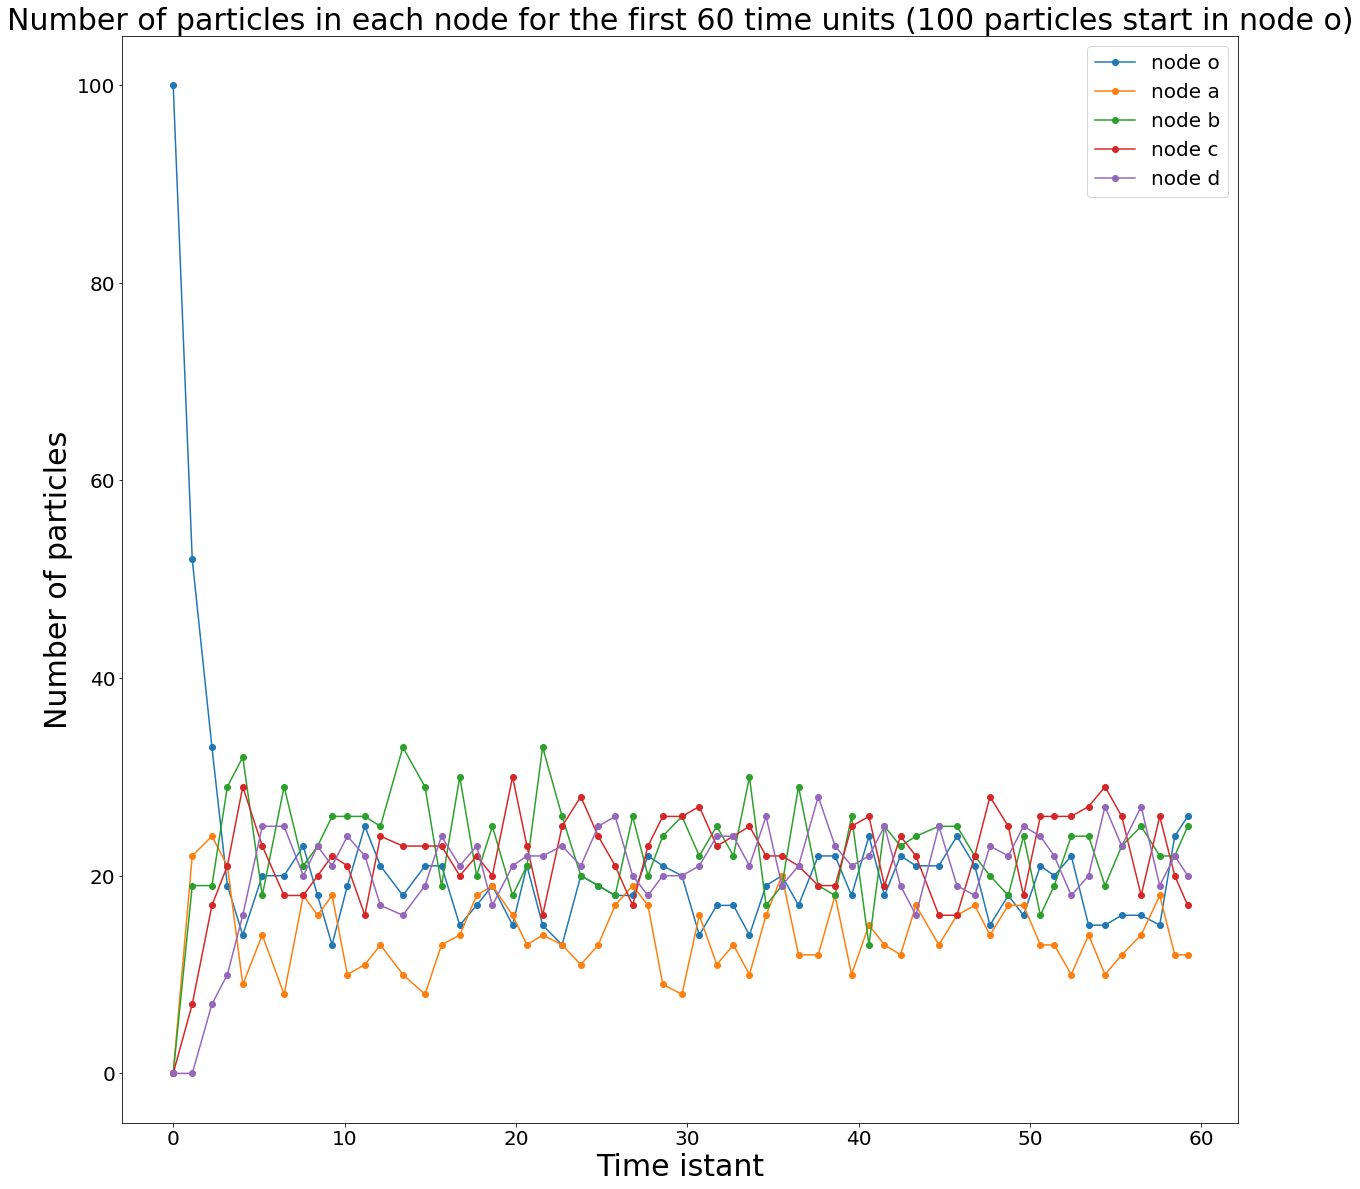

In [47]:
# plot the number of particles in each node for the first 60 time units
fig = plt.figure(1, figsize=(20,20))
ax = plt.subplot(111)

for node in range(len(G)):
    trajectory = nodes_part[:,node]
    ax.plot(transition_times[0::100], trajectory[0::100], '-o', label='node ' + sorted_nodes[node])  # for visualization purposes, only 1 point between 100 is plotted. (stop=100)
ax.legend(fontsize = 20)
plt.title('Number of particles in each node for the first 60 time units (100 particles start in node o)', fontsize = 30)
plt.xlabel('Time istant', fontsize = 30)
plt.ylabel('Number of particles', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)


# Number of particles in each node at the 60-th time unit istant
n_final = nodes_part[-1,:]
print("Number of particles in each node at the 60-th time unit istant (100 particles start in node o):")
for i in range(len(n_final)):
    print("Node " + sorted_nodes[i]+ ": " + str(int(n_final[i])))

In [17]:
n_simul = 20000
n_particles = 100
start = 'o'
coll_n = np.zeros((n_simul, len(G)))
for j in range(0, n_simul):
    transition_times, nodes_part, t_next = RandomWalk_NotUniformTransitionProbability__nodePerspective(P_bar, n_particles, w, sorted_nodes, 'o', final_time = 60, stop = 'final_time')
    n_final = nodes_part[-1,:]
    coll_n[j] = n_final
avg_n = coll_n.mean(axis=0)

print("Average number of particles in the different nodes after 60 time units (if 100 particles starts in o):", avg_n)

Average number of particles in the different nodes after 60 time units (if 100 particles starts in o): [18.5226  14.78055 22.2456  22.2406  22.21065]


In [22]:
# pi_bar: stationary distribution of the continuous-time random walk followed by the single particles (previuously computed)
# avg_n: average number of particles in the different nodes after 60 time units

avg_n = avg_n/np.sum(avg_n) # normalization


print("Stationary distribution of the continuous-time random walk followed by the single particles =", pi_bar, "\n")

print("Average number of particles in the different nodes after 60 time units =", avg_n, "\n")

error = np.linalg.norm(pi_bar-avg_n)
print("Comparison: ", error)

Stationary distribution of the continuous-time random walk followed by the single particles = [0.1851852 0.1481481 0.2222222 0.2222222 0.2222222] 

Average number of particles in the different nodes after 60 time units = [0.185226  0.1478055 0.222456  0.222406  0.2221065] 

Comparison:  0.0004699689032265675


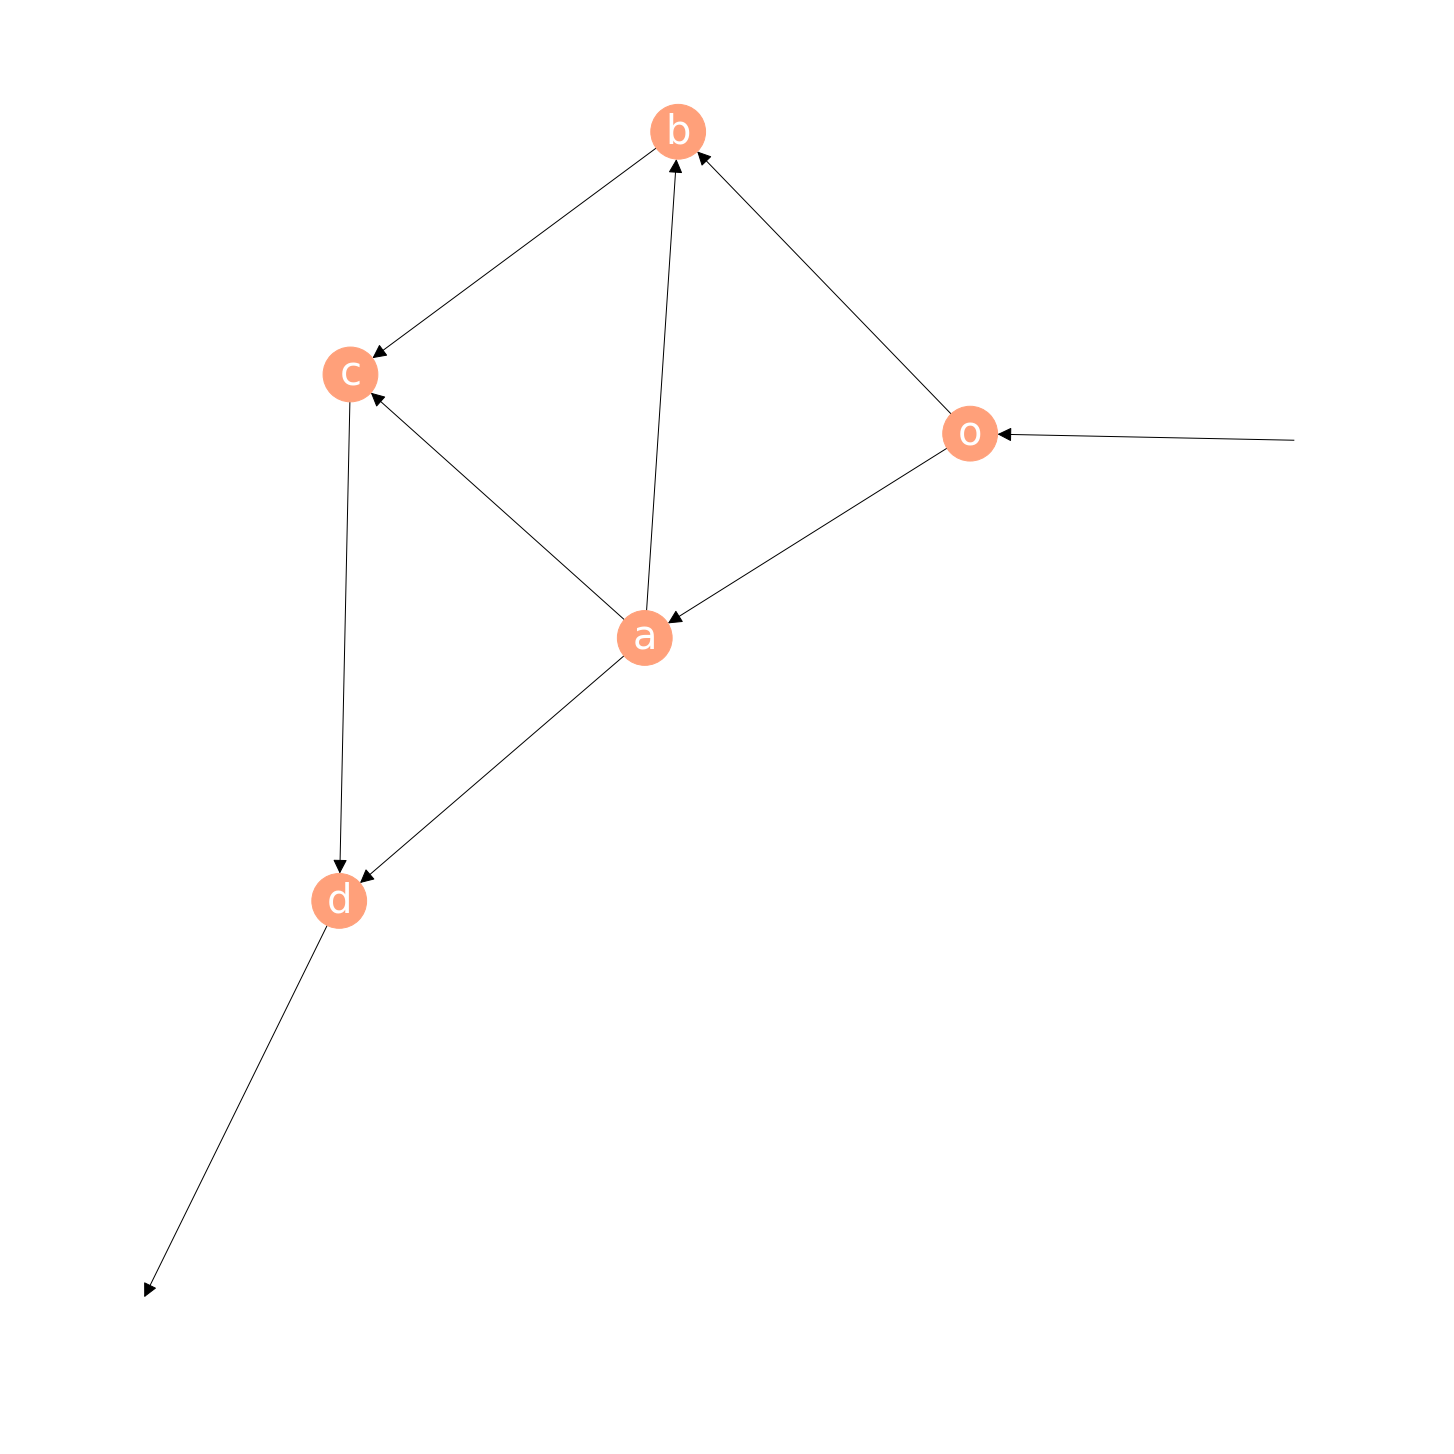

In [48]:
G = nx.DiGraph()
G.add_edges_from([('o','a'),('o','b'),('a','b'),('a','c'),('a','d'),('b','c'),('c','d')])

# (add 2 fictitious nodes to plot ingoing edge in o and outgoing edge from d)
G.add_edges_from([('x','o'),('d','y')])
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(20, 20))
n_color = ['#FFA07A','#FFA07A','#FFA07A','#FFA07A','#FFA07A','#ffffff','#ffffff']
nx.draw(G, pos, node_color=n_color, arrowsize=30, node_size=3000, font_size=40, font_color='white', with_labels=True)

# (restore original graph)
G = nx.DiGraph()
G.add_edges_from([('o','a'),('o','b'),('a','b'),('a','c'),('a','d'),('b','c'),('c','d')])

In [49]:
sorted_nodes = ['o', 'a', 'b', 'c', 'd']

# define a new graph with sorted nodes
H = nx.DiGraph()
H.add_nodes_from(sorted_nodes)
H.add_edges_from(G.edges(data=True))
print(list(H.nodes))

['o', 'a', 'b', 'c', 'd']


In [50]:
Lambda = [
[0, 3/4, 3/8, 0, 0],
[0, 0, 1/4, 1/4, 2/4],
[0, 0, 0, 1, 0],
[0, 0, 0, 0, 1],
[0, 0, 0, 0, 0]]

print("Lambda matrix: \n", np.array(Lambda))

Lambda matrix: 
 [[0.    0.75  0.375 0.    0.   ]
 [0.    0.    0.25  0.25  0.5  ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.   ]]


In [51]:
w = np.sum(Lambda, axis=1)
w[4] = 2
w_star = np.max(w)
print("w vector: \n", w)
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda
print("P matrix: \n", P)

w vector: 
 [1.125 1.    1.    1.    2.   ]
P matrix: 
 [[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.25       0.25       0.5       ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.         0.        ]]


In [52]:
# Simulates a random walk of multiple particles on a weighted graph, according to transition probability matrix P, starting from node 'start' to node 'end'.
# The random walk goes on for num_steps steps or for the first final_time final units. The termination condition can be expressed through the parameter stop, which can be set to 'final_time' or 'num_steps'
# rate parameter represents the rate nodes will pass along particles and can be set to 'proportional' or 'fixed'
# lambda_input parameter represents the rate of the Poisson Process according to which particles enter the system at node 'start'

# It returns a tuple(transition_times, enter_times, nodes_part, n_particles, t_next) such that:
# transition_times stores the time instants at which transitions happen
# enter_times stores the time istants in which particles enter the system
# nodes_part is a matrix whose rows i represent the i-th time istants in vector transition_times and whose columns j represent the number of particles in each node 
# n_particles stores the number of particles in the network at the end of the simulation
# t_next stores the last waiting time, useful to compute: transition_times[-1] + t_next, end of the time horizon.
def RandomWalk_NotUniformTransitionProbability__nodePerspective__openNetwork(P, lambda_input, w, nodes_list, start, end, num_steps = 1000000, final_time = 60, stop = 'num_steps', rate = 'proportional'):
    nstates = P.shape[0]
    start_index = nodes_list.index(start)
    end_index = nodes_list.index(end)
    
    # generate time istants in which particles enter the system
    #     Since the rate of the Poisson Process is fixed (= lambda_input) and does not depend on other parameters which can
    #     change during the simulation, time istants in which particles enter the system can be computed at the beginning
    enter_times = np.zeros(num_steps) # enter_times store the time instants at which particles enter the system
    size = num_steps 
    t_next = -np.log(np.random.rand())/lambda_input
    # Poisson clock with rate lambda_input
    if stop == 'num_steps':
        for i in range(1, num_steps):
            enter_times[i] = enter_times[i-1] + t_next
            t_next = -np.log(np.random.rand())/lambda_input
            # Poisson clock with rate lambda_input
    if stop == 'final_time':
        maxt = 0
        i = 1
        while maxt<=final_time:
            if i==size:
                size = size*2
                enter_times.resize(size, refcheck=False)
            enter_times[i] = enter_times[i-1] + t_next
            t_next = -np.log(np.random.rand())/lambda_input
            # Poisson clock with rate lambda_input
            maxt = enter_times[i]
            i+=1
        enter_times.resize(i, refcheck=False)
            
    
    nodes_part = np.zeros((num_steps, nstates)) # nodes_part keep trace of the number of particles in each node at each time istant    
    transition_times = np.zeros(num_steps) # transition_times store the time instants at which transitions happen for the particle
    size = num_steps
    
    n_particles = 1
    nodes_part[0,start_index] = n_particles # at time 0, 1 particle is in node 'start' while all other nodes are free
    
    w_star = np.max(w)
    if rate == 'proportional':
        t_next = -np.log(np.random.rand())/(nodes_part[0,:]@w)
        # System-wide Poisson clock with rate sum_j{nodes_part[i,j]*w[j]}.
    if rate == 'fixed':
        t_next = -np.log(np.random.rand())/(np.sum(w))
        # System-wide Poisson clock with rate sum_j{w[j]}.
    
    j = 1 # j represents the index in vector enter_times 
    
    if stop == 'num_steps':
        for i in range(1, num_steps):
            transition_times[i] = transition_times[i-1] + t_next # update transition_times
            nodes_part[i,:] = nodes_part[i-1,:]
            
            # update particles in nodes according to newly entered particles
            while(j<enter_times.shape[0] and enter_times[j]<=transition_times[i]):
                j += 1
                n_particles += 1
                nodes_part[i,start_index] += 1
                
            if np.sum(nodes_part[i,:]!=0): # if there are particles in the network
                if rate == 'proportional':
                    prob = (nodes_part[i,:]*w)/(nodes_part[i,:]@w) # probability to select a node j from which move a particle is nodes_part[i,j]*w[j] / sum_j{nodes_part[i,j]*w[j]}
                if rate == 'fixed':
                    prob = (w)/np.sum(w) # probability to select a node j from which move a particle is w[j] / sum_i{w[j]}
                node_selected = np.random.choice(nstates, p=prob) # randomly select a node from which move a particle
                if nodes_part[i, node_selected] != 0: # if there are particles in the node 
                    nodes_part[i,node_selected] -= 1 # update node from which a particle has been moved
            
                    if node_selected != end_index:
                        node_toMove = np.random.choice(nstates, p=P[node_selected,:])
                        nodes_part[i,node_toMove] += 1 # update node to which a particle has been moved
                    else:
                        n_particles -= 1
            
    
            if np.sum(nodes_part[i,:]==0): # if there are no particles in the network
                t_next = -np.log(np.random.rand())/(np.sum(w))
                # System-wide Poisson clock with rate sum_j{w[j]}.
            else:
                if rate == 'proportional':
                    t_next = -np.log(np.random.rand())/(nodes_part[i,:]@w) # waiting time to the next transition
                    # System-wide Poisson clock with rate sum_j{nodes_part[i,j]*w[j]}.
                if rate == 'fixed':
                    t_next = -np.log(np.random.rand())/(np.sum(w))
                    # System-wide Poisson clock with rate sum_j{w[j]}.
                
    if stop == 'final_time':
        maxt = 0
        i = 1
        while maxt<=final_time:
            if i==size:
                size = size*2
                transition_times.resize(size, refcheck=False)
                nodes_part.resize((size,n_states), refcheck=False)
            transition_times[i] = transition_times[i-1] + t_next # update transition_times
            nodes_part[i,:] = nodes_part[i-1,:]
            
            # update particles in nodes according to newly entered particles
            while(j<enter_times.shape[0] and enter_times[j]<=transition_times[i]):
                j += 1
                n_particles += 1
                nodes_part[i,start_index] += 1
            
            if np.sum(nodes_part[i,:]!=0): # if there are particles in the network
                if rate == 'proportional':
                    prob = (nodes_part[i,:]*w)/(nodes_part[i,:]@w) # probability to select a node j from which move a particle is nodes_part[i,j]*w[j] / sum_j{nodes_part[i,j]*w[j]}
                if rate == 'fixed':
                    prob = (w)/np.sum(w) # probability to select a node j from which move a particle is w[j] / sum_i{w[j]}
                node_selected = np.random.choice(nstates, p=prob) # randomly select a node from which move a particle
                if nodes_part[i, node_selected] != 0: # if there are particles in the node 
                    nodes_part[i,node_selected] -= 1 # update node from which a particle has been moved
            
                    if node_selected != end_index:
                        node_toMove = np.random.choice(nstates, p=P[node_selected,:])
                        nodes_part[i,node_toMove] += 1 # update node to which a particle has been moved
                    else:
                        n_particles -= 1
            
    
            if np.sum(nodes_part[i,:]==0): # if there are no particles in the network
                t_next = -np.log(np.random.rand())/(np.sum(w))
                # System-wide Poisson clock with rate sum_j{w[j]}.
            else:
                if rate == 'proportional':
                    t_next = -np.log(np.random.rand())/(nodes_part[i,:]@w) # waiting time to the next transition
                    # System-wide Poisson clock with rate sum_j{nodes_part[i,j]*w[j]}.
                if rate == 'fixed':
                    t_next = -np.log(np.random.rand())/(np.sum(w))
                    # System-wide Poisson clock with rate sum_j{w[j]}.
                
            maxt = transition_times[i]
            i+=1
        transition_times.resize(i, refcheck=False)
        nodes_part.resize((i,nstates), refcheck=False)
        
    return (transition_times, enter_times, nodes_part, n_particles, t_next)

In [53]:
transition_times, enter_times, nodes_part, t_next, n_particles = RandomWalk_NotUniformTransitionProbability__nodePerspective__openNetwork(P, 1, w, sorted_nodes, 'o', 'd', final_time = 60, stop = 'final_time', rate = 'proportional')

Number of particles in each node at the 60-th time unit istant (particles enter in o and exit in d) - Proportional rate:
Node o: 1
Node a: 0
Node b: 0
Node c: 1
Node d: 0


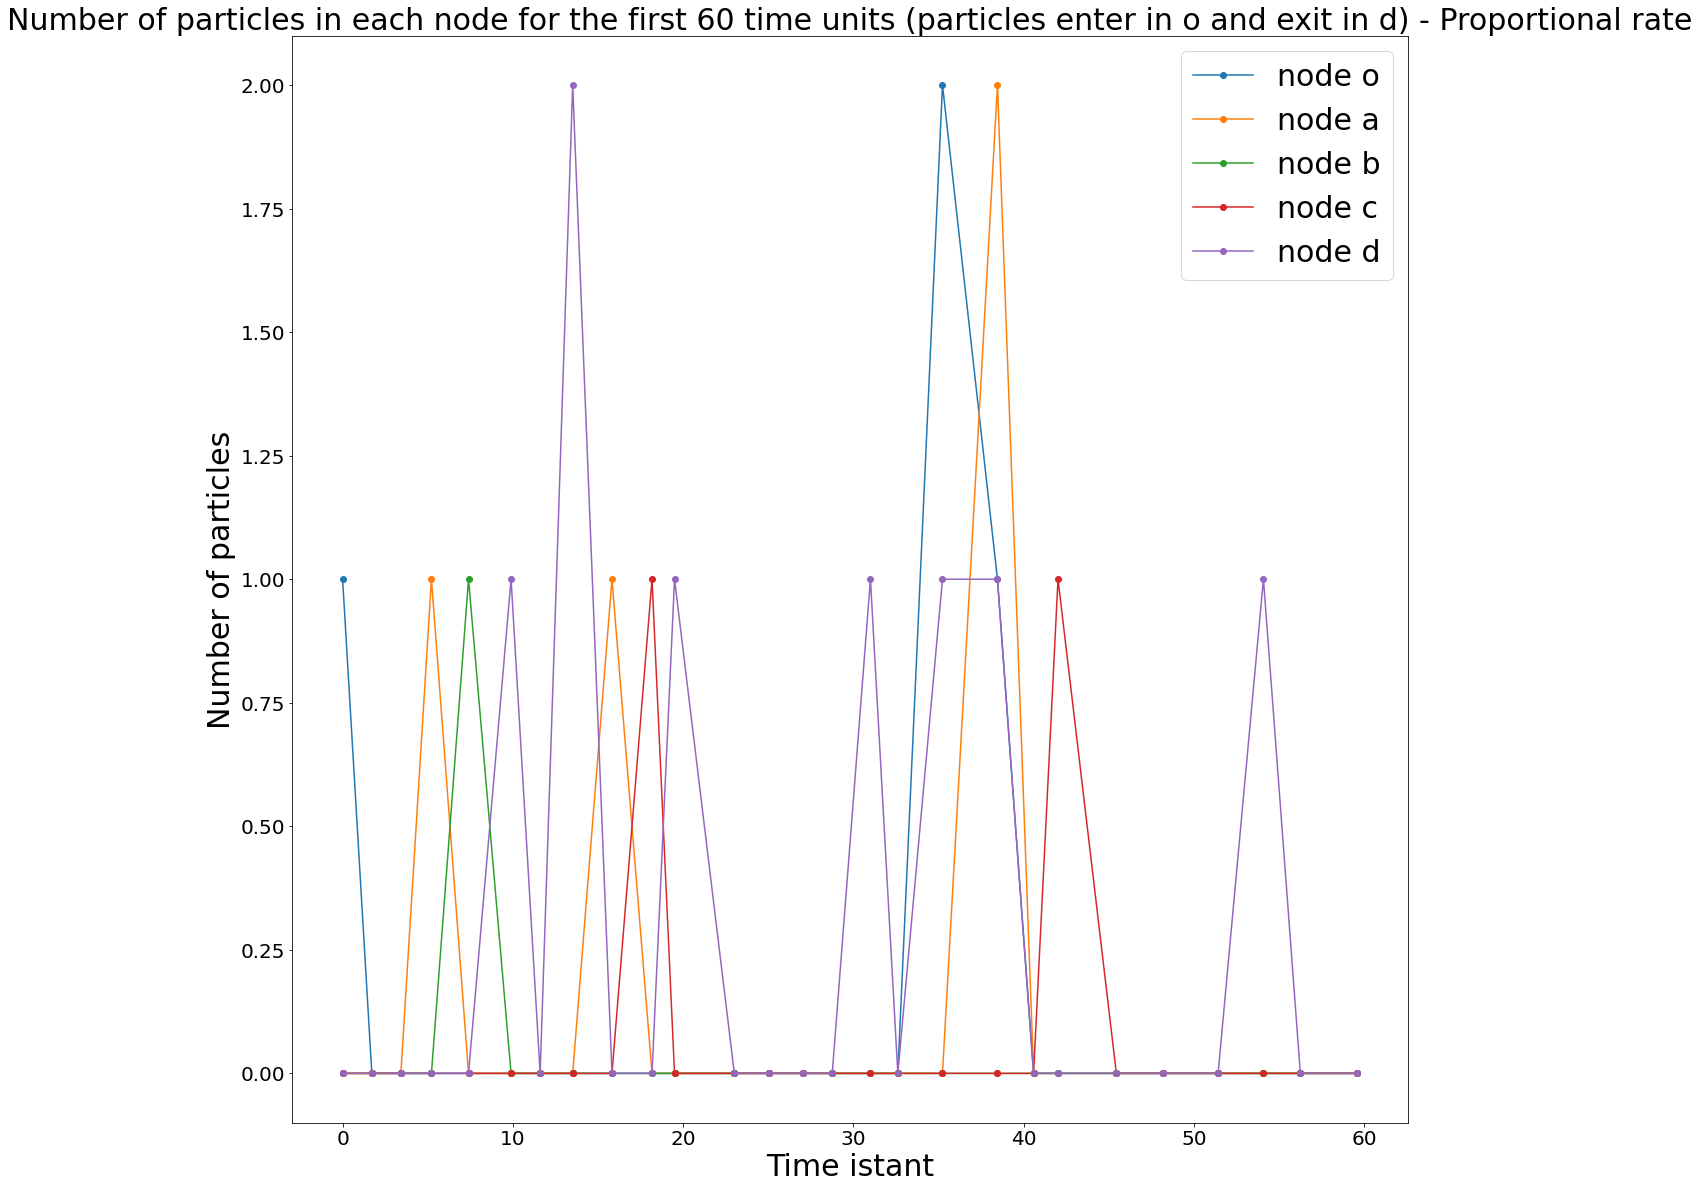

In [60]:
# Proportional rate.
# plot the number of particles in each node for the first 60 time units
fig = plt.figure(1, figsize=(20,20))
ax = plt.subplot(111)

for node in range(len(G)):
    trajectory = nodes_part[:,node]
    ax.plot(transition_times[0::15], trajectory[0::15], '-o', label='node ' + sorted_nodes[node])  # for visualization purposes, only 1 point between 15 is plotted. (stop=15)
ax.legend(fontsize = 30)
plt.title('Number of particles in each node for the first 60 time units (particles enter in o and exit in d) - Proportional rate', fontsize = 30)
plt.xlabel('Time istant', fontsize = 30)
plt.ylabel('Number of particles', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# Number of particles in each node at the 60-th time unit istant
n_final = nodes_part[-1,:]
print("Number of particles in each node at the 60-th time unit istant (particles enter in o and exit in d) - Proportional rate:")
for i in range(len(n_final)):
    print("Node " + sorted_nodes[i]+ ": " + str(int(n_final[i])))

In [64]:
transition_times, enter_times, nodes_part, t_next, n_particles = RandomWalk_NotUniformTransitionProbability__nodePerspective__openNetwork(P, 1, w, sorted_nodes, 'o', 'd', final_time = 60, stop = 'final_time', rate = 'fixed')

Number of particles in each node at the 60-th time unit istant (particles enter in o and exit in d) - Fixed rate:
Node o: 3
Node a: 4
Node b: 1
Node c: 1
Node d: 0


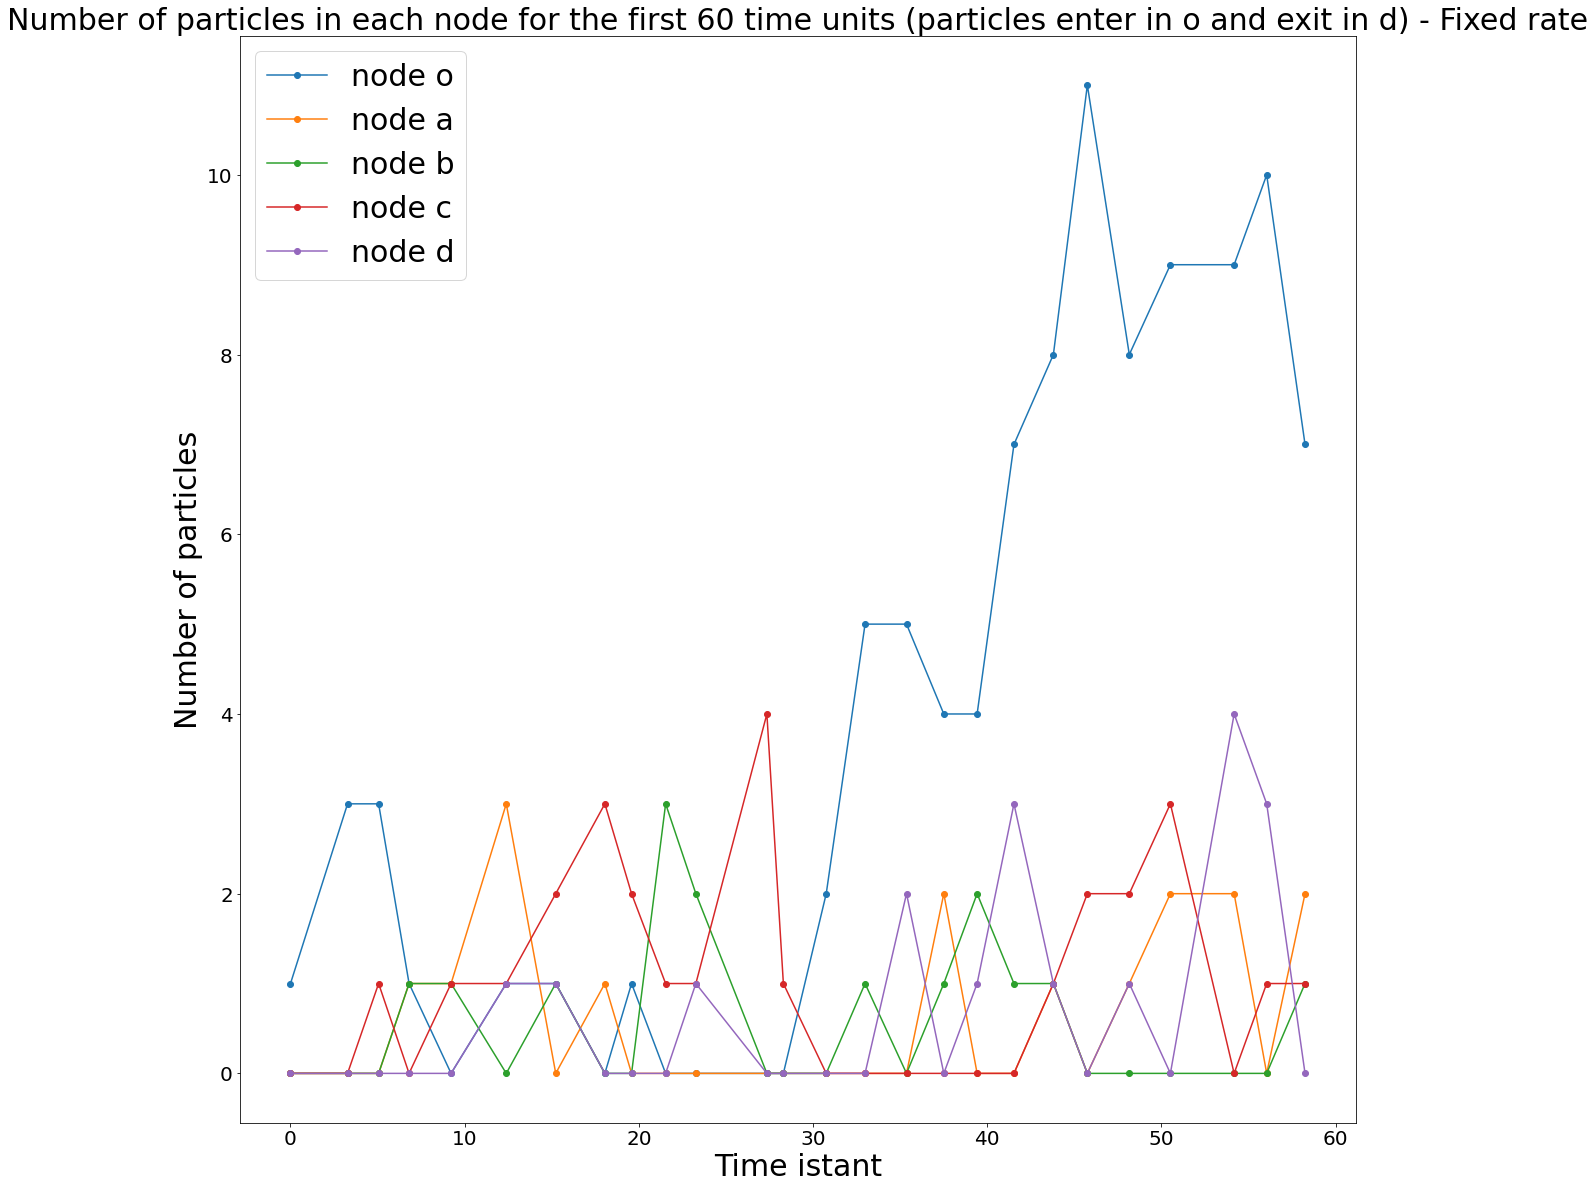

In [66]:
# Fixed rate.
# plot the number of particles in each node for the first 60 time units
fig = plt.figure(1, figsize=(20,20))
ax = plt.subplot(111)

for node in range(len(G)):
    trajectory = nodes_part[:,node]
    ax.plot(transition_times[0::15], trajectory[0::15], '-o', label='node ' + sorted_nodes[node])  # for visualization purposes, only 1 point between 15 is plotted. (stop=15)
ax.legend(fontsize = 30)
plt.title('Number of particles in each node for the first 60 time units (particles enter in o and exit in d) - Fixed rate', fontsize = 30)
plt.xlabel('Time istant', fontsize = 30)
plt.ylabel('Number of particles', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# Number of particles in each node at the 60-th time unit istant
n_final = nodes_part[-1,:]
print("Number of particles in each node at the 60-th time unit istant (particles enter in o and exit in d) - Fixed rate:")
for i in range(len(n_final)):
    print("Node " + sorted_nodes[i]+ ": " + str(int(n_final[i])))

In [10]:
# Proportional rate.
step = 0.05
start = 0
end = 3
n_simul = 1000
lambda_input__n_part = {}
for lambda_input in np.arange(start+step,end+step,step):
    n_part__coll = np.zeros(n_simul)
    for i in range(n_simul):
        transition_times, enter_times, nodes_part, t_next, n_particles = RandomWalk_NotUniformTransitionProbability__nodePerspective__openNetwork(P, lambda_input, w, sorted_nodes, 'o', 'd', final_time = 60, stop = 'final_time', rate = 'proportional')
        start_row = int(nodes_part.shape[0]/2) # consider only the second half of the vector nodes_part (i.e.: only the second part of time istants)
        n_final = nodes_part[start_row:,:] 
        n_part = np.sum(n_final, axis=1) # number of particles in the second half of the vector nodes_part (i.e.: only the second part of time istants)
        n_part_avg = np.mean(n_part) # average of the number of particles in the second half of the vector nodes_part (i.e.: only the second part of time istants)
        n_part__coll[i] = n_part_avg
    lambda_input__n_part[lambda_input] = np.mean(n_part__coll) # average betweein n_simul simulations

Text(0, 0.5, 'Number of particles')

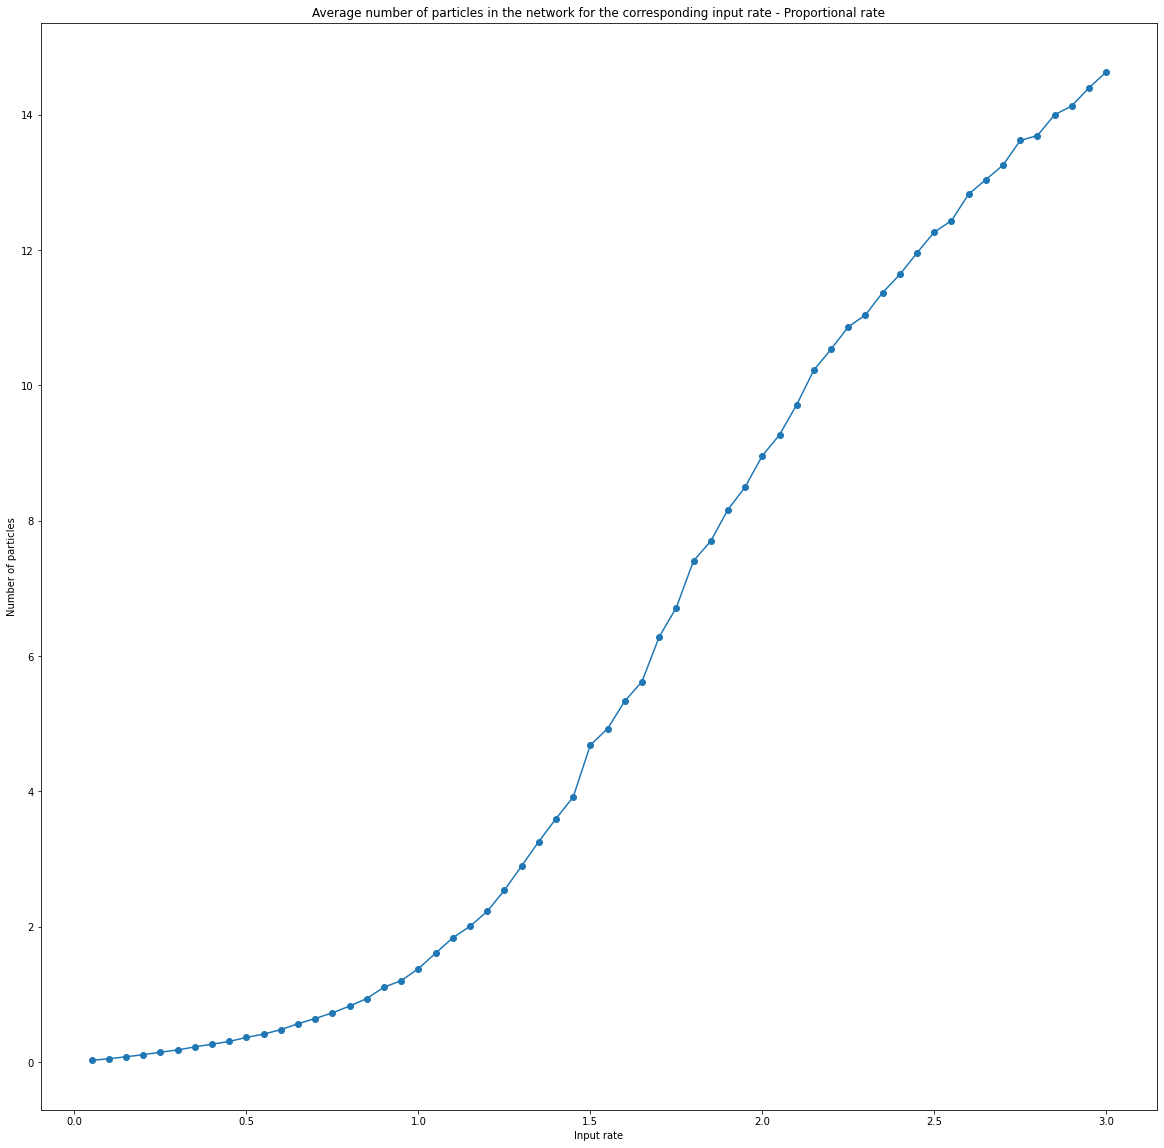

In [5]:
# plot the average number of particles in the network for the corresponding input rate - Proportional rate
fig = plt.figure(1, figsize=(20,20))
ax = plt.subplot(111)

ax.plot(lambda_input__n_part.keys(), lambda_input__n_part.values(), '-o')
plt.title('Average number of particles in the network for the corresponding input rate - Proportional rate')
plt.xlabel('Input rate')
plt.ylabel('Number of particles')

In [11]:
# Fixed rate.
step = 0.05
start = 0
end = 3
n_simul = 1000
lambda_input__n_part = {}
for lambda_input in np.arange(start+step,end+step,step):
    n_part__coll = np.zeros(n_simul)
    for i in range(n_simul):
        transition_times, enter_times, nodes_part, t_next, n_particles = RandomWalk_NotUniformTransitionProbability__nodePerspective__openNetwork(P, lambda_input, w, sorted_nodes, 'o', 'd', final_time = 60, stop = 'final_time', rate = 'fixed')
        start_row = int(nodes_part.shape[0]/2)  # consider only the second half of the vector nodes_part (i.e.: only the second part of time istants)
        n_final = nodes_part[start_row:,:]
        n_part = np.sum(n_final, axis=1) # number of particles in the second half of the vector nodes_part (i.e.: only the second part of time istants)
        n_part_avg = np.mean(n_part) # average of the number of particles in the second half of the vector nodes_part (i.e.: only the second part of time istants)
        n_part__coll[i] = n_part_avg
    lambda_input__n_part[lambda_input] = np.mean(n_part__coll) # average betweein n_simul simulations

Text(0, 0.5, 'Number of particles')

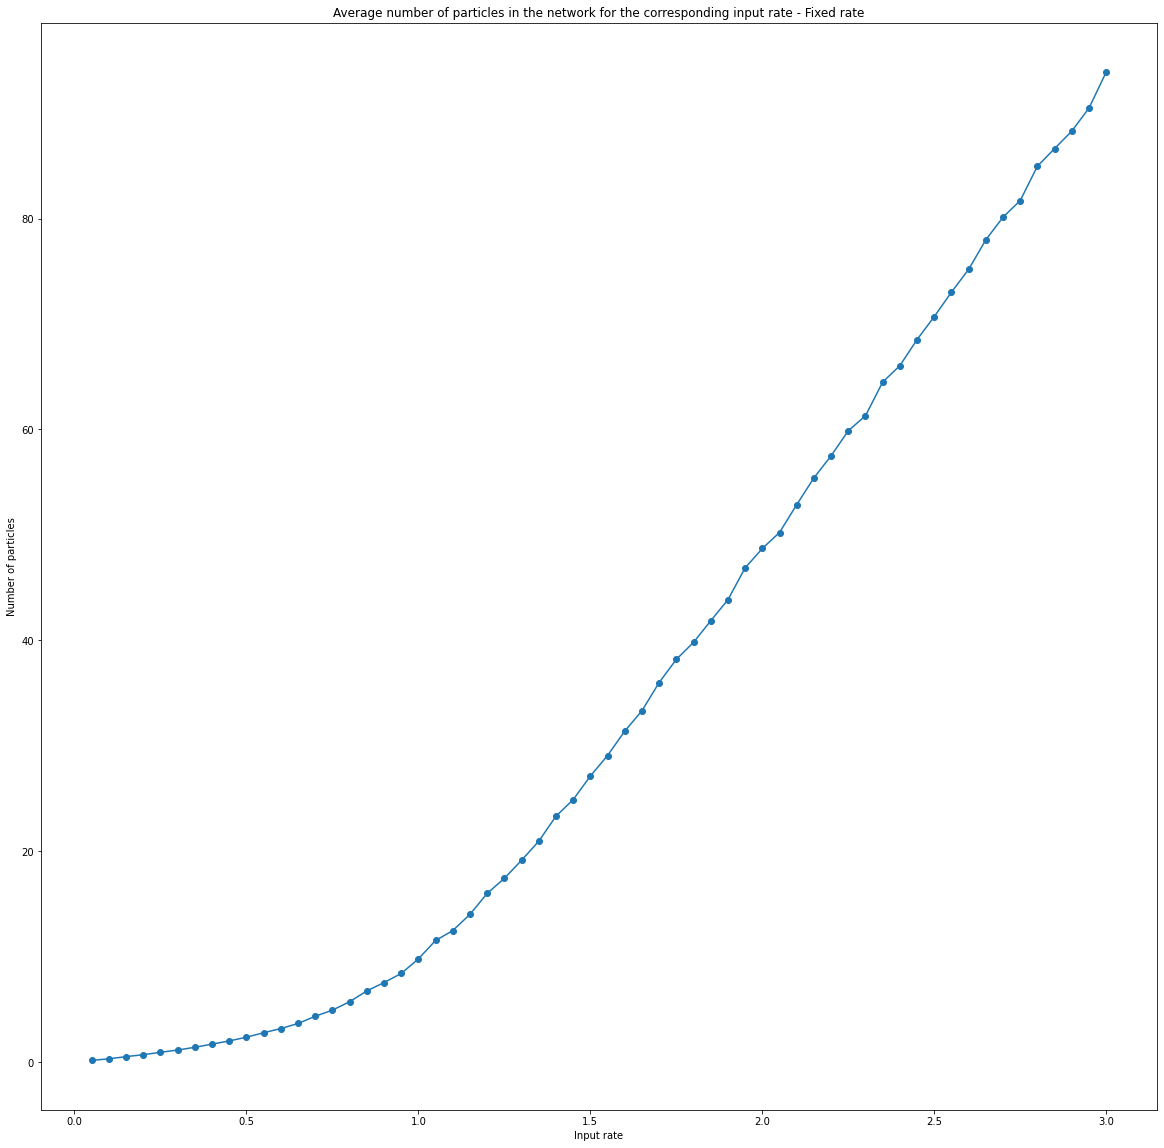

In [7]:
# plot the average number of particles in the network for the corresponding input rate - Fixed rate
fig = plt.figure(1, figsize=(20,20))
ax = plt.subplot(111)

ax.plot(lambda_input__n_part.keys(), lambda_input__n_part.values(), '-o')
plt.title('Average number of particles in the network for the corresponding input rate - Fixed rate')
plt.xlabel('Input rate')
plt.ylabel('Number of particles')